# Model Build V1

## Import Library

In [1]:
import cv2
import os
import json
import numpy as np
import subprocess
from datetime import datetime
import csv
import pandas as pd
import itertools
import random

## Frame Sampling

In [2]:
def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Tidak dapat membuka file video {video_path}.")
        return None, None, None
    
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frame per detik
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frame
    duration = frame_count / fps if fps > 0 else 0  # Durasi dalam detik
    
    cap.release()
    
    print(f"\n[INFO] Video: {video_path}")
    print(f"Durasi Video: {duration:.2f} detik")
    print(f"Frame Per Detik (FPS): {fps:.2f}")
    
    return fps, duration, frame_count

video_rotations = {
    "20250317_152346.mp4": 180,
    "VID_20241001_014146_00_033.mp4": 90,
    "VID_20241001_021251_00_034.mp4": 90,
    "VID_20241001_024253_00_035.mp4": 90,
    "VID_20241001_215144_00_036.mp4": 90,
    "VID_20241001_222146_00_037.mp4": 90,
    "VID_20241001_225148_00_038.mp4": 90,
}

def extract_frames(video_path, output_folder, frames_per_second):
    fps, duration, frame_count = get_video_info(video_path)
    if fps is None:
        return
    
    total_frames_to_capture = int(duration * frames_per_second)
    step_size = max(1, frame_count // total_frames_to_capture)

    os.makedirs(output_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    count = 0
    frame_index = 0

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    file_name = os.path.basename(video_path)

    rotation = video_rotations.get(file_name, 0)

    # Tentukan kode rotasi OpenCV
    if rotation == 90:
        rotate_code = cv2.ROTATE_90_CLOCKWISE
    elif rotation == 180:
        rotate_code = cv2.ROTATE_180
    elif rotation == 270:
        rotate_code = cv2.ROTATE_90_COUNTERCLOCKWISE
    else:
        rotate_code = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_index % step_size == 0 and count < total_frames_to_capture:
            if (rotate_code != None):
                frame = cv2.rotate(frame, rotate_code)
            frame_filename = os.path.join(output_folder, f"{video_name}_frame_{count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            print(f"Frame {count+1} disimpan: {frame_filename}")
            count += 1
        
        frame_index += 1

    cap.release()
    print(f"Total {count} frame berhasil disimpan di {output_folder}")

def process_all_videos(video_folder, frames_per_second):
    # Mendapatkan daftar semua file video dalam folder
    video_extensions = (".mp4", ".avi", ".mov", ".mkv")
    video_files = [f for f in os.listdir(video_folder) if f.lower().endswith(video_extensions)]
    
    if not video_files:
        print("Tidak ada file video yang ditemukan di folder videos.")
        return

    output_folder = "images"  # Output DIR
    for video_file in video_files:
        video_path = os.path.join(video_folder, video_file)
        print(f"\n=== Memproses: {video_file} ===")
        extract_frames(video_path, output_folder, frames_per_second)

# EXEC
video_folder = "videos"  # Input DIR
frames_per_second = 1  # Banyak Frame per Detik yang diambil sebagai sample

process_all_videos(video_folder, frames_per_second)


=== Memproses: 20250317_152346.mp4 ===

[INFO] Video: videos\20250317_152346.mp4
Durasi Video: 2656.32 detik
Frame Per Detik (FPS): 30.00
Frame 1 disimpan: images\20250317_152346_frame_0000.jpg
Frame 2 disimpan: images\20250317_152346_frame_0001.jpg
Frame 3 disimpan: images\20250317_152346_frame_0002.jpg
Frame 4 disimpan: images\20250317_152346_frame_0003.jpg
Frame 5 disimpan: images\20250317_152346_frame_0004.jpg
Frame 6 disimpan: images\20250317_152346_frame_0005.jpg
Frame 7 disimpan: images\20250317_152346_frame_0006.jpg
Frame 8 disimpan: images\20250317_152346_frame_0007.jpg
Frame 9 disimpan: images\20250317_152346_frame_0008.jpg
Frame 10 disimpan: images\20250317_152346_frame_0009.jpg
Frame 11 disimpan: images\20250317_152346_frame_0010.jpg
Frame 12 disimpan: images\20250317_152346_frame_0011.jpg
Frame 13 disimpan: images\20250317_152346_frame_0012.jpg
Frame 14 disimpan: images\20250317_152346_frame_0013.jpg
Frame 15 disimpan: images\20250317_152346_frame_0014.jpg
Frame 16 disimp

## PreProcessing Image

In [3]:
# Path utama untuk OpenPose dan direktori gambar
openpose_path = os.path.abspath("openpose")  # Path ke OpenPose
image_dir = os.path.abspath("../images")  # Folder gambar input
json_output_dir = os.path.abspath("../output_json")  # Folder JSON hasil OpenPose
preprocessing_dir = os.path.abspath("../preprocessing_images")  # Folder hasil crop
log_dir = os.path.abspath("../log_preprocessing")

# Tambahkan timestamp pada nama file log
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file_path = os.path.join(log_dir, f"error_log_preprocessing_{timestamp}.txt")

# Buat folder jika belum ada
os.makedirs(image_dir, exist_ok=True)
os.makedirs(json_output_dir, exist_ok=True)
os.makedirs(preprocessing_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Ambil file gambar dari folder `images/`
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

if not image_files:
    print("Tidak ada gambar yang valid di folder `images/`. Silakan unggah file JPG atau PNG!")
    exit()

# hitung jumlah gambar
total_images = len(image_files)
print(f"Preprocessing of {total_images} images!, please wait...")

# Jalankan OpenPose dengan `cwd=openpose_path`
cmd = [
    "bin\\OpenPoseDemo.exe",
    "--image_dir", image_dir,
    "--write_json", json_output_dir,
    "--display", "0",
    "--render_pose", "0",
    "--model_pose", "BODY_25",
    "--number_people_max", "1"
]

result = subprocess.run(cmd, shell=True, capture_output=True, text=True, cwd=openpose_path)

# **Periksa apakah OpenPose berjalan dengan sukses**
if result.returncode != 0:
    error_msg = "OpenPose gagal dijalankan! Periksa konfigurasi atau file gambar."
    print(error_msg)
    log_file.write(error_msg)
    exit()

# **Periksa apakah ada JSON hasil OpenPose**
json_files = [f for f in os.listdir(json_output_dir) if f.endswith(".json")]
if not json_files:
    error_msg = "Tidak ada JSON yang dihasilkan oleh OpenPose! Pastikan gambar terdeteksi dengan benar."
    print(error_msg)
    log_file.write(error_msg)
    exit()

# Buka file log untuk mencatat error
with open(log_file_path, "w") as log_file:
    for index, image_file in enumerate(image_files, start=1):
        input_image_path = os.path.join(image_dir, image_file)
        file_name, file_ext = os.path.splitext(image_file)

        output_json_path = os.path.join(json_output_dir, file_name + '_keypoints.json')

        # Tampilkan progress
        print(f"Memproses ({index}/{total_images}): {image_file} ...")

        if result.returncode != 0:
            error_msg = f"Gagal memproses {image_file} dengan OpenPose!\n"
            print(error_msg)
            log_file.write(error_msg)
            continue

        # Baca hasil JSON dari OpenPose
        if not os.path.exists(output_json_path):
            error_msg = f"JSON hasil deteksi tidak ditemukan untuk {image_file}!\n"
            print(error_msg)
            log_file.write(error_msg)
            continue

        with open(output_json_path, 'r') as f:
            pose_data = json.load(f)
            if not pose_data['people']:
                error_msg = f"Tidak ada orang terdeteksi pada {image_file}.\n"
                print(error_msg)
                log_file.write(error_msg)
                continue
            keypoints = pose_data['people'][0]['pose_keypoints_2d']

        # Ambil koordinat x, y untuk semua keypoints
        def get_coords(index):
            x = keypoints[index * 3]
            y = keypoints[index * 3 + 1]
            confidence = keypoints[index * 3 + 2]
            return (int(x), int(y)) if confidence > 0 else None

        def get_coords_flip(index):
            return (keypoints[index * 3], keypoints[index * 3 + 1]) if keypoints and keypoints[index * 3 + 2] > 0 else None

        body_points = [get_coords(i) for i in range(25)]
        valid_points = [p for p in body_points if p is not None]

        if not valid_points:
            error_msg = f"Tidak ada titik tubuh yang valid pada {image_file}.\n"
            print(error_msg)
            log_file.write(error_msg)
            continue

        # Cari bounding box (xmin, ymin, xmax, ymax)
        x_coords, y_coords = zip(*valid_points)
        xmin, xmax = min(x_coords), max(x_coords)
        ymin, ymax = min(y_coords), max(y_coords)

        # Tambahkan margin ekstra (10% dari bounding box)
        margin_x = int((xmax - xmin) * 0.1)
        margin_y = int((ymax - ymin) * 0.1)

        xmin, ymin = max(0, xmin - margin_x), max(0, ymin - margin_y)
        xmax, ymax = min(xmax + margin_x, 9999), min(ymax + margin_y, 9999)  # 9999 untuk menjaga batas atas

        # Tentukan ukuran bounding box agar tetap 1:1
        box_size = max(xmax - xmin, ymax - ymin)

        # Hitung posisi baru agar tetap dalam batas gambar
        x_center, y_center = (xmin + xmax) // 2, (ymin + ymax) // 2
        xmin, ymin = x_center - box_size // 2, y_center - box_size // 2
        xmax, ymax = x_center + box_size // 2, y_center + box_size // 2

        # Pastikan bounding box tetap dalam ukuran gambar
        img = cv2.imread(input_image_path)
        h, w, _ = img.shape

        # Hitung padding yang diperlukan
        pad_top, pad_bottom, pad_left, pad_right = 0, 0, 0, 0

        if xmin < 0:
            pad_left = abs(xmin)
            xmin = 0
        if xmax > w:
            pad_right = xmax - w
            xmax = w
        if ymin < 0:
            pad_top = abs(ymin)
            ymin = 0
        if ymax > h:
            pad_bottom = ymax - h
            ymax = h

        # Crop gambar sesuai bounding box yang diperbaiki
        cropped_img = img[ymin:ymax, xmin:xmax]

        # Tambahkan padding abu-abu agar tetap 1:1 dan objek di tengah
        cropped_img = cv2.copyMakeBorder(
            cropped_img, pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT, value=(128, 128, 128)  # Warna abu-abu
        )

        # Resize gambar ke ukuran standar 256x256
        final_size = (256, 256)
        resized_img = cv2.resize(cropped_img, final_size)

        # Simpan hasil crop
        preprocessing_image_path = os.path.join(preprocessing_dir, f"{file_name}_preproc{file_ext}")

        # Ambil titik hidung dan bahu
        nose = get_coords(0)  # Hidung
        left_shoulder = get_coords(5)  # Bahu kiri
        left_elbow = get_coords(6)  # Siku kiri
        left_wrist = get_coords(7)  # Pergelangan tangan kiri
        left_knee = get_coords(13)  # Lutut kiri

        score = 0

        if nose and left_shoulder:
            if nose[0] < left_shoulder[0]:  
                score += 1  # Menghadap kiri
            else:
                score -= 1  # Menghadap kanan
        
        if left_shoulder and left_wrist:
            if left_shoulder[0] > left_wrist[0]:  
                score += 1  # Menghadap kiri
            else:
                score -= 1  # Menghadap kanan
        
        if left_shoulder and left_knee:
            if left_shoulder[0] > left_knee[0]:  
                score += 1  # Menghadap kiri
            else:
                score -= 1  # Menghadap kanan
        
        if left_shoulder and left_elbow:
            if left_shoulder[0] > left_elbow[0]:  
                score += 1  # Menghadap kiri
            else:
                score -= 1  # Menghadap kanan

        if score > 0:
            print("Menghadap kiri → Flip ke kanan")
            img = resized_img
            flipped_img = cv2.flip(img, 1)  # Flip horizontal
            cv2.imwrite(preprocessing_image_path, flipped_img)
        elif score < 0:
            cv2.imwrite(preprocessing_image_path, resized_img)
        else:
            error_msg = f"Skor netral, tidak bisa menentukan arah hadap pada {image_file}.\n"
            print(error_msg)
            log_file.write(error_msg)
            continue

# Ambil file gambar dari folder `preprocessing_images/`
image_files_output = [f for f in os.listdir(preprocessing_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
total_images_output = len(image_files_output)
failed_image_process = total_images - total_images_output
print(f"\nTotal file berhasil diproses = {total_images_output}")
print(f"Total file gagal diproses = {failed_image_process}")

print(f"\nSemua gambar berhasil diproses. Hasil disimpan di folder `preprocessing_images/`.\n")
print(f"Log error tersimpan di: {log_file_path}")

Preprocessing of 10895 images!, please wait...
Memproses (1/10895): 20250317_152346_frame_0000.jpg ...
Memproses (2/10895): 20250317_152346_frame_0001.jpg ...
Memproses (3/10895): 20250317_152346_frame_0002.jpg ...
Memproses (4/10895): 20250317_152346_frame_0003.jpg ...
Memproses (5/10895): 20250317_152346_frame_0004.jpg ...
Memproses (6/10895): 20250317_152346_frame_0005.jpg ...
Memproses (7/10895): 20250317_152346_frame_0006.jpg ...
Memproses (8/10895): 20250317_152346_frame_0007.jpg ...
Memproses (9/10895): 20250317_152346_frame_0008.jpg ...
Memproses (10/10895): 20250317_152346_frame_0009.jpg ...
Memproses (11/10895): 20250317_152346_frame_0010.jpg ...
Memproses (12/10895): 20250317_152346_frame_0011.jpg ...
Memproses (13/10895): 20250317_152346_frame_0012.jpg ...
Memproses (14/10895): 20250317_152346_frame_0013.jpg ...
Memproses (15/10895): 20250317_152346_frame_0014.jpg ...
Memproses (16/10895): 20250317_152346_frame_0015.jpg ...
Memproses (17/10895): 20250317_152346_frame_0016.j

## Ekstraksi Fitur

In [2]:
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    v1 = a - b
    v2 = c - b
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def calculate_wrist_bending(elbow, wrist, hand_middle):
    # vektor lengan bawah
    forearm_vec = np.array(wrist) - np.array(elbow)
    # vektor arah tangan
    hand_vec = np.array(hand_middle) - np.array(wrist)
    # hitung sudut antar dua vektor
    cosine = np.dot(forearm_vec, hand_vec) / (np.linalg.norm(forearm_vec) * np.linalg.norm(hand_vec))
    angle = np.arccos(np.clip(cosine, -1, 1))
    return np.degrees(angle)

def calculate_neck_angle(back, neck, head):
    back = np.array(back)
    neck = np.array(neck)
    head = np.array(head)

    vertical_vec = neck - back     # vektor tubuh (vertikal)
    neck_vec = head - neck         # vektor arah leher

    cosine = np.dot(vertical_vec, neck_vec) / (np.linalg.norm(vertical_vec) * np.linalg.norm(neck_vec))
    angle = np.arccos(np.clip(cosine, -1.0, 1.0))
    return np.degrees(angle)

def calculate_trunk_deviation(hip, neck):
    """
    Mengukur deviasi trunk (badan) terhadap garis vertikal dari hip ke atas.
    hip: (x, y) titik mid-hip (BODY_25 keypoint 8)
    neck: (x, y) titik neck (BODY_25 keypoint 1)
    """
    hip = np.array(hip)
    neck = np.array(neck)
    
    # Buat garis (vertikal ke atas dari hip, sejajar sumbu Y)
    ideal_neck = np.array([hip[0], neck[1]])

    # Vektor ideal (vertikal lurus)
    vertical_vec = hip - ideal_neck
    # Vektor tubuh aktual
    trunk_vec = hip - neck

    # Sudut antara keduanya
    cosine = np.dot(vertical_vec, trunk_vec) / (np.linalg.norm(vertical_vec) * np.linalg.norm(trunk_vec))
    angle = np.arccos(np.clip(cosine, -1.0, 1.0))
    return np.degrees(angle)

def shoulder_is_raised(shoulder, neck, conf_shoulder, conf_neck, threshold=0.3):
    """
    Mengembalikan True jika shoulder lebih tinggi dari back (Y lebih kecil),
    dan confidence keduanya memadai.
    """
    if conf_shoulder > threshold and conf_neck > threshold:
        return shoulder[1] < neck[1]
    return False

def arm_is_supported():
    """
    Diasumsikan duduk di kursi/meja → arm selalu disupport.
    """
    return True

def is_neck_twisted(neck, nose, conf_neck, conf_nose, threshold=0.3):
    """
    Mengembalikan True jika posisi nose(0) di kiri neck(1) leher sedang twist
    """
    if conf_neck > threshold and conf_nose > threshold:
        return nose[0] < neck[0]
    elif conf_nose < 0.1:
        return True
    return False

def is_trunk_twisted_by_elbow_rule(
    elbow_r, elbow_l,
    shoulder_r, shoulder_l,
    conf_er, conf_el,
    conf_sr, conf_sl,
    threshold=0.3
):
    if conf_er > threshold and conf_el > threshold and conf_sr > threshold and conf_sl > threshold:
        twist_kiri = elbow_r[0] < shoulder_l[0]  # Twist ke kiri / frontal
        twist_kanan = elbow_l[0] < shoulder_r[0]  # Twist ke kanan berlebihan
        return twist_kiri or twist_kanan
    return False

# Path setup
openpose_path = os.path.abspath("openpose")
image_dir = os.path.abspath("../preprocessing_images")
output_dir = os.path.abspath("../output_images")
json_output_dir = os.path.abspath("../output_estimation_json")
csv_output_dir = os.path.abspath("../output_csv")
csv_output_path = os.path.abspath("../output_csv/output_angles.csv")

os.makedirs(image_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(json_output_dir, exist_ok=True)
os.makedirs(csv_output_dir, exist_ok=True)

image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

if not image_files:
    print("Tidak ada gambar yang valid di folder `preprocessing_images/`. Silakan unggah file JPG atau PNG!")
    exit()

# Jalankan OpenPose sekali untuk seluruh gambar
cmd = [
    "bin\\OpenPoseDemo.exe",
    "--image_dir", image_dir,
    "--write_images", output_dir,
    "--write_json", json_output_dir,
    "--display", "0",
    "--render_pose", "1",
    "--model_pose", "BODY_25",
    "--hand",
    "--number_people_max", "1"
]

print("Memproses seluruh gambar dengan OpenPose...")

result = subprocess.run(cmd, shell=True, capture_output=True, text=True, cwd=openpose_path)

if result.returncode != 0:
    print("Terjadi kesalahan saat menjalankan OpenPose!")
    print("Error Log:", result.stderr)
    exit()
else:
    print("Proses OpenPose selesai!")

# Siapkan CSV
csv_header = [
    "nama_gambar",
    "sudut_lutut",
    "sudut_siku",
    "sudut_leher",
    "sudut_punggung",
    "sudut_pergelangan",
    "sudut_bahu",

    # Confidence
    "conf_hip",
    "conf_knee",
    "conf_ankle",
    "conf_shoulder",
    "conf_shoulder_left",
    "conf_elbow",
    "conf_elbow_left",
    "conf_wrist",
    "conf_neck",
    "conf_head",
    "conf_back",
    "conf_hand_middle",

    # sub step poin
    "adjust_shoulder_raised",
    "adjust_arm_supported",
    "adjust_wrist_twist",
    "adjust_neck_twist",
    "adjust_trunk_twist",
    "adjust_legs_feet"
]
csv_rows = []

# Proses hasil JSON dari output
json_files = [f for f in os.listdir(json_output_dir) if f.endswith('_keypoints.json')]

for json_file in json_files:
    file_name = os.path.splitext(json_file)[0].replace('_keypoints', '')
    json_path = os.path.join(json_output_dir, json_file)

    with open(json_path, 'r') as f:
        pose_data = json.load(f)
        if not pose_data['people']:
            print(f"Tidak terdeteksi orang dalam gambar {file_name}")
            continue
        keypoints = pose_data['people'][0]['pose_keypoints_2d']
        hand_keypoints = pose_data['people'][0].get('hand_right_keypoints_2d', [])

    def get_coords(index):
        return (keypoints[index * 3], keypoints[index * 3 + 1]) if keypoints[index * 3 + 2] > 0 else None

    def get_hand_coords(index):
        return (hand_keypoints[index * 3], hand_keypoints[index * 3 + 1]) if hand_keypoints and len(hand_keypoints) > index * 3 + 2 and hand_keypoints[index * 3 + 2] > 0 else None

    def get_conf_body(index):
        return keypoints[index * 3 + 2] if len(keypoints) > index * 3 + 2 else 0
        
    def get_conf_hand(index):
        return hand_keypoints[index * 3 + 2] if len(hand_keypoints) > index * 3 + 2 else 0

    hip = get_coords(9)
    knee = get_coords(10)
    ankle = get_coords(11)
    shoulder = get_coords(2)
    shoulder_left = get_coords(5)
    elbow = get_coords(3)
    elbow_left = get_coords(6)
    wrist = get_coords(4)
    neck = get_coords(1)
    head = get_coords(17)
    back = get_coords(8)
    nose = get_coords(0)

    hand_middle = get_hand_coords(12)

    conf_hip = get_conf_body(9)
    conf_knee = get_conf_body(10)
    conf_ankle = get_conf_body(11)
    conf_shoulder = get_conf_body(2)
    conf_shoulder_left = get_conf_body(5)
    conf_elbow = get_conf_body(3)
    conf_elbow_left = get_conf_body(6)
    conf_wrist = get_conf_body(4)
    conf_neck = get_conf_body(1)
    conf_head = get_conf_body(17)
    conf_back = get_conf_body(8)
    conf_nose = get_conf_body(0)

    conf_hand_middle = get_conf_hand(12)

    print(f"\nGambar: {file_name}")
    row = [file_name]
    
    elbow_angle = None
    knee_angle = None
    neck_angle = None
    trunk_angle = None
    wrist_angle = None
    shoulder_angle = None

    if hip and knee and ankle:
        knee_angle = calculate_angle(hip, knee, ankle)
        print(f"Sudut Lutut: {knee_angle:.2f}°")
        row.append(knee_angle)
    else:
        row.append(None)

    if shoulder and elbow and wrist:
        elbow_angle = abs(180 - calculate_angle(shoulder, elbow, wrist))
        print(f"Sudut Siku: {elbow_angle:.2f}°")
        row.append(elbow_angle)
    else:
        row.append(None)

    if back and neck and head:
        neck_angle = calculate_neck_angle(back, neck, head)
        print(f"Sudut Leher: {neck_angle:.2f}°")
        row.append(neck_angle)
    else:
        row.append(None)

    if hip and neck:
        trunk_angle = calculate_trunk_deviation(hip, neck)
        print(f"Sudut Trunk: {trunk_angle:.2f}°")
        row.append(trunk_angle)
    else:
        row.append(None)

    if elbow and wrist and hand_middle:
        wrist_angle = calculate_wrist_bending(elbow, wrist, hand_middle)
        print(f"Sudut Pergelangan Tangan: {wrist_angle:.2f}°")
        row.append(wrist_angle)
    else:
        row.append(None)

    if back and shoulder and elbow:
        shoulder_angle = calculate_angle(back, shoulder, elbow)
        print(f"Sudut Fleksi/Ekstensi Bahu: {shoulder_angle:.2f}°")
        row.append(shoulder_angle)
    else:
        row.append(None)

    # Sub Step Point RULA/REBA
    # 1a
    adjust_shoulder = 1 if shoulder_is_raised(shoulder, neck, conf_shoulder, conf_neck) else 0
    adjust_supported = -1 if arm_is_supported() else 0

    # 4 (di set ke 1 karena normal dan ada batasan mapping)
    adjust_wrist_twist = 1

    # 9a (hanya untuk twist)
    adjust_neck_twist = 1 if is_neck_twisted(neck, nose, conf_neck, conf_nose) else 0

    # 10a (hanya untuk twist)
    adjust_trunk_twist = 1 if is_trunk_twisted_by_elbow_rule(
        elbow, elbow_left,
        shoulder, shoulder_left,
        conf_elbow, conf_elbow_left,
        conf_shoulder, conf_shoulder_left
    ) else 0

    # 11 (set ke 1 karena tidak ada sudut pasti untuk kaki)
    adjust_legs_feet = 1

    row.extend([
        conf_hip,
        conf_knee,
        conf_ankle,
        conf_shoulder,
        conf_shoulder_left,
        conf_elbow,
        conf_elbow_left,
        conf_wrist,
        conf_neck,
        conf_head,
        conf_back,
        conf_hand_middle,
        adjust_shoulder,
        adjust_supported,
        adjust_wrist_twist,
        adjust_neck_twist,
        adjust_trunk_twist,
        adjust_legs_feet
    ])

    csv_rows.append(row)

with open(csv_output_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)
    writer.writerows(csv_rows)

Memproses seluruh gambar dengan OpenPose...

Gambar: 20250317_152346_frame_0000_preproc
Sudut Lutut: 82.34°
Sudut Siku: 32.82°
Sudut Leher: 7.16°
Sudut Trunk: 2.76°
Sudut Pergelangan Tangan: 36.18°
Sudut Fleksi/Ekstensi Bahu: 31.71°

Gambar: 20250317_152346_frame_0001_preproc
Sudut Lutut: 80.41°
Sudut Siku: 31.06°
Sudut Leher: 16.96°
Sudut Trunk: 2.15°
Sudut Pergelangan Tangan: 5.90°
Sudut Fleksi/Ekstensi Bahu: 31.19°

Gambar: 20250317_152346_frame_0002_preproc
Sudut Lutut: 81.09°
Sudut Siku: 28.14°
Sudut Leher: 26.69°
Sudut Trunk: 0.01°
Sudut Pergelangan Tangan: 134.11°
Sudut Fleksi/Ekstensi Bahu: 34.58°

Gambar: 20250317_152346_frame_0003_preproc
Sudut Lutut: 79.47°
Sudut Siku: 24.64°
Sudut Leher: 8.44°
Sudut Trunk: 2.77°
Sudut Pergelangan Tangan: 115.85°
Sudut Fleksi/Ekstensi Bahu: 31.58°

Gambar: 20250317_152346_frame_0004_preproc
Sudut Lutut: 80.64°
Sudut Siku: 27.24°
Sudut Leher: 4.53°
Sudut Trunk: 1.78°
Sudut Pergelangan Tangan: 3.58°
Sudut Fleksi/Ekstensi Bahu: 27.21°

Gambar: 

## Preprocessing Data

### Import File

In [30]:
# Load file hasil mentah
df = pd.read_csv("/output_csv/output_angles.csv")
df.head()

nama_gambar  sudut_lutut  sudut_siku  sudut_leher  \
0  20250317_152346_frame_0000_preproc    82.343020   32.819685     7.157090   
1  20250317_152346_frame_0001_preproc    80.413598   31.063688    16.957043   
2  20250317_152346_frame_0002_preproc    81.086473   28.142230    26.685976   
3  20250317_152346_frame_0003_preproc    79.473027   24.640675     8.444868   
4  20250317_152346_frame_0004_preproc    80.638978   27.237626     4.527877   

   sudut_punggung  sudut_pergelangan  sudut_bahu  conf_hip  conf_knee  \
0        2.759003          36.182153   31.711609  0.330333   0.638367   
1        2.149798           5.899618   31.186015  0.304208   0.668057   
2        0.011532         134.113121   34.580102  0.316732   0.663823   
3        2.769748         115.847109   31.580247  0.338053   0.714458   
4        1.779873           3.583243   27.205172  0.344573   0.680110   

   conf_ankle  ...  conf_neck  conf_head  conf_back  conf_hand_middle  \
0    0.515560  ...   0.654634   0.802631   0.309171          0.000781   
1    0.511834  ...   0.641461   0.811721   0.268024          0.004583   
2    0.470857  ...   0.633463   0.857472   0.240373          0.005632   
3    0.473630  ...   0.686783   0.831166   0.296611          0.009816   
4    0.464147  ...   0.666943   0.837150   0.324353          0.008473   

   adjust_shoulder_raised  adjust_arm_supported  adjust_wrist_twist  \
0                       0                    -1                   1   
1                       0                    -1                   1   
2                       1                    -1                   1   
3                       0                    -1                   1   
4                       0                    -1                   1   

   adjust_neck_twist  adjust_trunk_twist  adjust_legs_feet  
0                  0                   0                 1  
1                  0                   0                 1  
2                  0                   0                 1  
3                  0                   0                 1  
4                  0                   1                 1  

[5 rows x 25 columns]

### Cek Missing Value & Baris Rusak

In [31]:
# Cek kolom dengan NaN
print("Jumlah nilai kosong per kolom:")
print(df.isnull().sum())

# Tampilkan baris yang punya NaN
df[df.isnull().any(axis=1)]

Jumlah nilai kosong per kolom:
nama_gambar                  0
sudut_lutut               1624
sudut_siku                 322
sudut_leher                579
sudut_punggung             750
sudut_pergelangan          325
sudut_bahu                 559
conf_hip                     0
conf_knee                    0
conf_ankle                   0
conf_shoulder                0
conf_shoulder_left           0
conf_elbow                   0
conf_elbow_left              0
conf_wrist                   0
conf_neck                    0
conf_head                    0
conf_back                    0
conf_hand_middle             0
adjust_shoulder_raised       0
adjust_arm_supported         0
adjust_wrist_twist           0
adjust_neck_twist            0
adjust_trunk_twist           0
adjust_legs_feet             0
dtype: int64


nama_gambar  sudut_lutut  sudut_siku  \
21                20250317_152346_frame_0021_preproc    85.334426         NaN   
22                20250317_152346_frame_0022_preproc    82.468986         NaN   
23                20250317_152346_frame_0023_preproc    83.874602         NaN   
24                20250317_152346_frame_0024_preproc    85.986121         NaN   
25                20250317_152346_frame_0025_preproc    88.136310         NaN   
...                                              ...          ...         ...   
10303  VID_20241001_225148_00_038_frame_0512_preproc          NaN   56.693754   
10304  VID_20241001_225148_00_038_frame_0513_preproc          NaN   56.086953   
10305  VID_20241001_225148_00_038_frame_0514_preproc          NaN   54.194084   
10306  VID_20241001_225148_00_038_frame_0515_preproc          NaN   52.394250   
10307  VID_20241001_225148_00_038_frame_0516_preproc          NaN   94.324004   

       sudut_leher  sudut_punggung  sudut_pergelangan  sudut_bahu  conf_hip  \
21        2.023661       32.941399                NaN   28.229847  0.295128   
22        4.049572       36.390753                NaN   26.824231  0.285246   
23        0.155121       37.929327                NaN   28.240995  0.214014   
24        1.333821       37.715020                NaN   31.722816  0.267177   
25        0.444216       35.022816                NaN   32.723288  0.287373   
...            ...             ...                ...         ...       ...   
10303          NaN        0.524756          18.835308   44.795743  0.464063   
10304          NaN        2.750491          27.995532   46.273099  0.453613   
10305          NaN        1.502188          25.070857   47.048789  0.456402   
10306          NaN        0.480853          19.126909   48.111545  0.448896   
10307    10.141180        0.008442          51.661920   49.570002  0.410485   

       conf_knee  conf_ankle  ...  conf_neck  conf_head  conf_back  \
21      0.702970    0.425109  ...   0.590402   0.887486   0.243636   
22      0.682515    0.504397  ...   0.526904   0.868034   0.196293   
23      0.643853    0.237459  ...   0.481371   0.823691   0.148606   
24      0.654795    0.528636  ...   0.486584   0.862739   0.186943   
25      0.723102    0.490771  ...   0.529729   0.833902   0.214317   
...          ...         ...  ...        ...        ...        ...   
10303   0.599620    0.000000  ...   0.711578   0.000000   0.543496   
10304   0.592239    0.000000  ...   0.659489   0.000000   0.512398   
10305   0.612846    0.000000  ...   0.693917   0.000000   0.527907   
10306   0.623074    0.000000  ...   0.706743   0.000000   0.514941   
10307   0.642603    0.000000  ...   0.781696   0.893386   0.467495   

       conf_hand_middle  adjust_shoulder_raised  adjust_arm_supported  \
21             0.000000                       1                    -1   
22             0.000000                       0                    -1   
23             0.000000                       1                    -1   
24             0.000000                       1                    -1   
25             0.000000                       0                    -1   
...                 ...                     ...                   ...   
10303          0.430973                       0                    -1   
10304          0.100799                       0                    -1   
10305          0.119596                       0                    -1   
10306          0.116590                       0                    -1   
10307          0.251134                       0                    -1   

       adjust_wrist_twist  adjust_neck_twist  adjust_trunk_twist  \
21                      1                  0                   1   
22                      1                  0                   0   
23                      1                  0                   0   
24                      1                  0                   0   
25                      1                  0                 

### Melakukan perubahan NaN ke 0 karena dianggap sudut tidak terbentuk

In [33]:
angle_cols = [col for col in df.columns if col.startswith("sudut_")]
df[angle_cols] = df[angle_cols].fillna(0)

### Simpan Hasil Cleansing

In [34]:
df.to_csv("/output_csv/output_angles_cleaned.csv", index=False)
print("File cleaned disimpan sebagai: output_angles_cleaned.csv")

File cleaned disimpan sebagai: output_angles_cleaned.csv


## Augmentasi Data

In [35]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/output_csv/output_angles_cleaned.csv")  # Ganti path jika perlu

# Kolom sudut yang akan diaugmentasi
sudut_cols = [
    'sudut_lutut', 'sudut_siku', 'sudut_leher',
    'sudut_punggung', 'sudut_pergelangan', 'sudut_bahu'
]

# Fungsi augmentasi
def augment_sudut(data, n_aug=2, noise_range=3):
    augmented_rows = []
    for i in range(n_aug):
        aug_data = data.copy()
        for col in sudut_cols:
            noise = np.random.uniform(-noise_range, noise_range, size=len(data))
            aug_data[col] = np.clip(aug_data[col] + noise, 0, 180)  # batasi ke 0–180
        aug_data["nama_gambar"] += f"_aug{i+1}"
        augmented_rows.append(aug_data)
    return pd.concat(augmented_rows, ignore_index=True)

df_augmented = augment_sudut(df, n_aug=2)
df_combined = pd.concat([df, df_augmented], ignore_index=True)
df_combined.to_csv("/output_csv/output_angles_augmented.csv", index=False)
print("Dataset augmentasi berbasis data asli berhasil dibuat.")

Dataset augmentasi berbasis data asli berhasil dibuat.


## Scoring RULA

In [36]:
df = pd.read_csv("/output_csv/output_angles_augmented.csv")

def calculate_upper_arm_score(sudut_bahu, shoulder_raised, arm_supported):
    # Step 1: Skor dasar berdasarkan sudut bahu
    if sudut_bahu < 20:
        base_score = 1
    elif 20 <= sudut_bahu < 45:
        base_score = 2
    elif 45 <= sudut_bahu < 90:
        base_score = 3
    else:  # sudut_bahu >= 90
        base_score = 4

    # Step 1a: Penyesuaian
    base_score += shoulder_raised       # +1 jika bahu terangkat
    base_score += arm_supported         # -1 jika disangga

    return base_score

# Terapkan fungsi ke setiap baris DataFrame
df["rula_upper_arm_score"] = df.apply(
    lambda row: calculate_upper_arm_score(
        row["sudut_bahu"],
        row["adjust_shoulder_raised"],
        row["adjust_arm_supported"]
    ),
    axis=1
)

# Fungsi untuk menghitung skor Lower Arm (RULA Step 2)
def calculate_lower_arm_score(sudut_siku):
    if 60 <= sudut_siku <= 100:
        return 1
    elif 0 <= sudut_siku < 60:
        return 2
    else:  # sudut_siku > 100
        return 2

# Terapkan fungsi ke setiap baris
df["rula_lower_arm_score"] = df["sudut_siku"].apply(calculate_lower_arm_score)

# Fungsi untuk menghitung skor Wrist Position (RULA Step 3)
def calculate_wrist_score(sudut_pergelangan):
    if sudut_pergelangan == 0:
        return 1
    elif 0 < sudut_pergelangan <= 15:
        return 2
    else:  # sudut_pergelangan > 15
        return 3

# Terapkan fungsi ke setiap baris
df["rula_wrist_score"] = df["sudut_pergelangan"].apply(calculate_wrist_score)

# Fungsi untuk lookup skor di Table A (Step 5)
def lookup_table_a(upper_arm, lower_arm, wrist, wrist_twist):
    # Batasi rentang ke maksimal sesuai tabel (1–6 untuk upper, 1–3 untuk lower, 1–4 untuk wrist, 1–2 untuk twist)
    upper = max(1, min(6, upper_arm))
    lower = max(1, min(3, lower_arm))
    wrist_score = max(1, min(4, wrist))
    twist = max(1, min(2, wrist_twist))
    
    # Tabel A versi nested dictionary [upper][lower][wrist][twist]
    table_a = {
        1: {1: {1: {1: 1, 2: 2}, 2: {1: 2, 2: 2}, 3: {1: 2, 2: 3}, 4: {1: 3, 2: 3}},
            2: {1: {1: 2, 2: 2}, 2: {1: 2, 2: 2}, 3: {1: 3, 2: 3}, 4: {1: 3, 2: 3}},
            3: {1: {1: 2, 2: 3}, 2: {1: 3, 2: 3}, 3: {1: 3, 2: 3}, 4: {1: 4, 2: 4}}},
        2: {1: {1: {1: 2, 2: 3}, 2: {1: 3, 2: 3}, 3: {1: 3, 2: 4}, 4: {1: 4, 2: 4}},
            2: {1: {1: 3, 2: 3}, 2: {1: 3, 2: 3}, 3: {1: 3, 2: 4}, 4: {1: 4, 2: 4}},
            3: {1: {1: 3, 2: 4}, 2: {1: 4, 2: 4}, 3: {1: 4, 2: 4}, 4: {1: 5, 2: 5}}},
        3: {1: {1: {1: 3, 2: 3}, 2: {1: 4, 2: 4}, 3: {1: 4, 2: 4}, 4: {1: 5, 2: 5}},
            2: {1: {1: 3, 2: 4}, 2: {1: 4, 2: 4}, 3: {1: 4, 2: 4}, 4: {1: 5, 2: 5}},
            3: {1: {1: 4, 2: 4}, 2: {1: 4, 2: 4}, 3: {1: 4, 2: 5}, 4: {1: 5, 2: 5}}},
        4: {1: {1: {1: 4, 2: 4}, 2: {1: 4, 2: 4}, 3: {1: 4, 2: 5}, 4: {1: 5, 2: 5}},
            2: {1: {1: 4, 2: 4}, 2: {1: 4, 2: 4}, 3: {1: 4, 2: 5}, 4: {1: 5, 2: 5}},
            3: {1: {1: 4, 2: 4}, 2: {1: 4, 2: 5}, 3: {1: 5, 2: 5}, 4: {1: 6, 2: 6}}},
        5: {1: {1: {1: 5, 2: 5}, 2: {1: 5, 2: 5}, 3: {1: 5, 2: 6}, 4: {1: 6, 2: 7}},
            2: {1: {1: 5, 2: 6}, 2: {1: 6, 2: 6}, 3: {1: 6, 2: 7}, 4: {1: 7, 2: 7}},
            3: {1: {1: 6, 2: 6}, 2: {1: 6, 2: 7}, 3: {1: 7, 2: 7}, 4: {1: 7, 2: 8}}},
        6: {1: {1: {1: 7, 2: 7}, 2: {1: 7, 2: 7}, 3: {1: 7, 2: 8}, 4: {1: 8, 2: 9}},
            2: {1: {1: 8, 2: 8}, 2: {1: 8, 2: 8}, 3: {1: 8, 2: 9}, 4: {1: 9, 2: 9}},
            3: {1: {1: 9, 2: 9}, 2: {1: 9, 2: 9}, 3: {1: 9, 2: 9}, 4: {1: 9, 2: 9}}},
    }

    return table_a[upper][lower][wrist_score][twist]

# Terapkan fungsi ke setiap baris
df["rula_posture_score_a"] = df.apply(lambda row: lookup_table_a(
    row["rula_upper_arm_score"],
    row["rula_lower_arm_score"],
    row["rula_wrist_score"],
    row["adjust_wrist_twist"]
), axis=1)

# Step 6 dan 7 untuk A diasumsikan 0
df["rula_muscle_score_a"] = 0
df["rula_force_score_a"] = 0

# Step 8: Total Wrist & Arm Score (Table A total)
df["rula_score_a_total"] = (
    df["rula_posture_score_a"] +
    df["rula_muscle_score_a"] +
    df["rula_force_score_a"]
)

# Fungsi untuk menghitung skor Neck Position (RULA Step 9)
def calculate_neck_score(sudut_leher, neck_twist):
    # Skor dasar berdasarkan sudut
    if sudut_leher <= 10:
        base_score = 1
    elif sudut_leher <= 20:
        base_score = 2
    elif sudut_leher > 20:
        base_score = 3
    else:  # kebelakang
        base_score = 4

    # Penyesuaian jika leher twisted
    base_score += neck_twist  # +1 jika twisted (sudah 0 atau 1)

    return base_score

# Terapkan ke setiap baris
df["rula_neck_score"] = df.apply(lambda row: calculate_neck_score(
    row["sudut_leher"],
    row["adjust_neck_twist"]
), axis=1)

# Fungsi untuk menghitung skor Trunk Position (RULA Step 10)
def calculate_trunk_score(sudut_punggung, trunk_twist):
    if sudut_punggung <= 0:
        base_score = 1
    elif sudut_punggung <= 20:
        base_score = 2
    elif sudut_punggung <= 60:
        base_score = 3
    else:  # sudut_punggung > 60
        base_score = 4

    # Penyesuaian jika trunk twisted
    base_score += trunk_twist  # +1 jika twisted (sudah 0 atau 1)

    return base_score

# Terapkan ke setiap baris
df["rula_trunk_score"] = df.apply(lambda row: calculate_trunk_score(
    row["sudut_punggung"],
    row["adjust_trunk_twist"]
), axis=1)

# Step 11: Hitung skor kaki
def calculate_leg_score(adjust_legs_feet):
    return 1 if adjust_legs_feet == 1 else 2

df["rula_leg_score"] = df["adjust_legs_feet"].apply(calculate_leg_score)

# Mapping akurat Table B [neck][trunk][legs]
table_b = {
    1: {
        1: {1: 1, 2: 3},
        2: {1: 2, 2: 3},
        3: {1: 3, 2: 4},
        4: {1: 5, 2: 5},
        5: {1: 6, 2: 6},
        6: {1: 7, 2: 7},
    },
    2: {
        1: {1: 2, 2: 3},
        2: {1: 2, 2: 3},
        3: {1: 4, 2: 5},
        4: {1: 5, 2: 5},
        5: {1: 6, 2: 7},
        6: {1: 7, 2: 7},
    },
    3: {
        1: {1: 3, 2: 3},
        2: {1: 3, 2: 4},
        3: {1: 4, 2: 5},
        4: {1: 5, 2: 6},
        5: {1: 6, 2: 7},
        6: {1: 7, 2: 7},
    },
    4: {
        1: {1: 5, 2: 5},
        2: {1: 5, 2: 6},
        3: {1: 6, 2: 7},
        4: {1: 7, 2: 7},
        5: {1: 7, 2: 7},
        6: {1: 8, 2: 8},
    },
    5: {
        1: {1: 7, 2: 7},
        2: {1: 7, 2: 7},
        3: {1: 7, 2: 8},
        4: {1: 8, 2: 8},
        5: {1: 8, 2: 8},
        6: {1: 8, 2: 8},
    },
    6: {
        1: {1: 8, 2: 8},
        2: {1: 8, 2: 8},
        3: {1: 8, 2: 8},
        4: {1: 8, 2: 9},
        5: {1: 9, 2: 9},
        6: {1: 9, 2: 9},
    },
}

# Fungsi untuk lookup Table B yang sudah diperbaiki
def lookup_table_b(neck_score, trunk_score, leg_score):
    neck = max(1, min(6, neck_score))
    trunk = max(1, min(6, trunk_score))
    legs = max(1, min(2, leg_score))
    return table_b[neck][trunk][legs]

# Terapkan
df["rula_posture_score_b"] = df.apply(lambda row: lookup_table_b(
    row["rula_neck_score"],
    row["rula_trunk_score"],
    row["rula_leg_score"]
), axis=1)

# Step 13 dan 14: Muscle Use dan Force/Load diasumsikan 0
df["rula_muscle_score_b"] = 0
df["rula_force_score_b"] = 0

# Step 15: Jumlahkan nilai dari step 12–14
df["rula_score_b_total"] = (
    df["rula_posture_score_b"] +
    df["rula_muscle_score_b"] +
    df["rula_force_score_b"]
)

# Mapping tabel C [A_total][B_total]
table_c = {
    1: {1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 5, 7: 5},
    2: {1: 2, 2: 2, 3: 3, 4: 4, 5: 4, 6: 5, 7: 5},
    3: {1: 3, 2: 3, 3: 3, 4: 4, 5: 4, 6: 5, 7: 6},
    4: {1: 3, 2: 3, 3: 3, 4: 4, 5: 5, 6: 6, 7: 6},
    5: {1: 4, 2: 4, 3: 4, 4: 5, 5: 6, 6: 7, 7: 7},
    6: {1: 4, 2: 4, 3: 5, 4: 6, 5: 6, 6: 7, 7: 7},
    7: {1: 5, 2: 5, 3: 6, 4: 6, 5: 7, 6: 7, 7: 7},
    8: {1: 5, 2: 5, 3: 6, 4: 7, 5: 7, 6: 7, 7: 7},
    9: {1: 5, 2: 5, 3: 6, 4: 7, 5: 7, 6: 7, 7: 7},
}

# Fungsi untuk lookup Table C
def lookup_table_c(score_a, score_b):
    a = max(1, min(9, score_a))
    b = min(7, max(1, score_b))  # B_total di atas 7 dipetakan ke 7+
    return table_c[a][b]

# Tambahkan final RULA score ke kolom baru
df["rula_final_score"] = df.apply(lambda row: lookup_table_c(
    row["rula_score_a_total"],
    row["rula_score_b_total"]
), axis=1)

# Simpan ke file baru
df.to_csv("/output_csv/output_angles_with_rula.csv", index=False)

## Scoring REBA

In [37]:
df = pd.read_csv("/output_csv/output_angles_with_rula.csv")

# Fungsi skor leher untuk REBA Step 1
def calculate_reba_neck_score(sudut_leher, neck_twist):
    if sudut_leher <= 20:
        base_score = 1
    elif sudut_leher > 20:
        base_score = 2
    else:  # kebelakang
        base_score = 2

    base_score += neck_twist  # +1 jika twisted
    return base_score

# Terapkan
df["reba_neck_score"] = df.apply(lambda row: calculate_reba_neck_score(
    float(row["sudut_leher"]),
    int(row["adjust_neck_twist"])
), axis=1)

# Fungsi skor trunk untuk REBA Step 2
def calculate_reba_trunk_score(sudut_punggung, trunk_twist):
    if sudut_punggung <= 0:
        base_score = 1
    elif sudut_punggung <= 20:
        base_score = 2
    elif sudut_punggung <= 60:
        base_score = 3
    else:  # sudut_punggung > 60
        base_score = 4

    base_score += trunk_twist  # +1 jika twisted
    return base_score

# Terapkan
df["reba_trunk_score"] = df.apply(lambda row: calculate_reba_trunk_score(
    float(row["sudut_punggung"]),
    int(row["adjust_trunk_twist"])
), axis=1)

# Step 3 REBA: Semua leg score di-set ke 1
df["reba_leg_score"] = 1

# Mapping REBA Table A [trunk][neck][leg]
reba_table_a = {
    1: {
        1: {1: 1, 2: 2, 3: 3, 4: 4},
        2: {1: 1, 2: 2, 3: 3, 4: 4},
        3: {1: 3, 2: 3, 3: 5, 4: 6},
    },
    2: {
        1: {1: 2, 2: 3, 3: 4, 4: 5},
        2: {1: 3, 2: 4, 3: 5, 4: 6},
        3: {1: 4, 2: 5, 3: 6, 4: 7},
    },
    3: {
        1: {1: 2, 2: 4, 3: 5, 4: 6},
        2: {1: 4, 2: 5, 3: 6, 4: 7},
        3: {1: 5, 2: 6, 3: 7, 4: 8},
    },
    4: {
        1: {1: 3, 2: 5, 3: 6, 4: 7},
        2: {1: 5, 2: 6, 3: 7, 4: 8},
        3: {1: 6, 2: 7, 3: 8, 4: 9},
    },
    5: {
        1: {1: 4, 2: 6, 3: 7, 4: 8},
        2: {1: 6, 2: 7, 3: 8, 4: 9},
        3: {1: 7, 2: 8, 3: 9, 4: 9},
    },
}

def lookup_reba_table_a(trunk, neck, leg):
    trunk = max(1, min(5, trunk))
    neck = max(1, min(3, neck))
    leg = max(1, min(4, leg))
    return reba_table_a[trunk][neck][leg]

# Terapkan ke DataFrame
df["reba_posture_score_a"] = df.apply(lambda row: lookup_reba_table_a(
    int(row["reba_trunk_score"]),
    int(row["reba_neck_score"]),
    int(row["reba_leg_score"])  # nanti bisa kamu upgrade ke 1–4 sesuai deteksi
), axis=1)

# Set semua force/load score ke 0 (karena diasumsikan ringan)
df["reba_force_score"] = 0

# Step 6: Hitung Score A
df["reba_score_a"] = df["reba_posture_score_a"] + df["reba_force_score"]

# Step 7: Upper Arm
def calculate_reba_upper_arm_score(sudut_bahu, shoulder_raised, arm_supported):
    if sudut_bahu < 20:
        base_score = 1
    elif 20 <= sudut_bahu < 45:
        base_score = 2
    elif 45 <= sudut_bahu < 90:
        base_score = 3
    else:  # sudut_bahu >= 90
        base_score = 4

    # Penyesuaian
    base_score += shoulder_raised      # +1 jika bahu terangkat
    base_score += arm_supported        # -1 jika lengan disangga (sudah bernilai -1)

    return base_score

# Terapkan ke DataFrame
df["reba_upper_arm_score"] = df.apply(lambda row: calculate_reba_upper_arm_score(
    float(row["sudut_bahu"]),
    int(row["adjust_shoulder_raised"]),
    int(row["adjust_arm_supported"])
), axis=1)

def calculate_reba_lower_arm_score(sudut_siku):
    if 60 <= sudut_siku <= 100:
        return 1
    elif 0 <= sudut_siku < 60:
        return 2
    else:  # sudut_siku > 100
        return 2

# Terapkan
df["reba_lower_arm_score"] = df["sudut_siku"].astype(float).apply(calculate_reba_lower_arm_score)

def calculate_reba_wrist_score(sudut_pergelangan):
    if sudut_pergelangan <= 15:
        return 1
    else:
        return 2

# Terapkan
df["reba_wrist_score"] = df["sudut_pergelangan"].astype(float).apply(calculate_reba_wrist_score)

# Mapping Table B: [upper_arm][lower_arm][wrist]
reba_table_b = {
    1: {1: {1: 1, 2: 2, 3: 2}, 2: {1: 1, 2: 2, 3: 3}},
    2: {1: {1: 1, 2: 2, 3: 3}, 2: {1: 2, 2: 3, 3: 4}},
    3: {1: {1: 3, 2: 4, 3: 5}, 2: {1: 4, 2: 5, 3: 5}},
    4: {1: {1: 4, 2: 5, 3: 5}, 2: {1: 5, 2: 6, 3: 7}},
    5: {1: {1: 6, 2: 7, 3: 8}, 2: {1: 7, 2: 8, 3: 8}},
    6: {1: {1: 7, 2: 8, 3: 8}, 2: {1: 8, 2: 9, 3: 9}},
}

def lookup_reba_table_b(upper, lower, wrist):
    upper = max(1, min(6, upper))
    lower = max(1, min(2, lower))
    wrist = max(1, min(3, wrist))  # kita treat skor wrist max 3
    return reba_table_b[upper][lower][wrist]

# Terapkan ke DataFrame
df["reba_posture_score_b"] = df.apply(lambda row: lookup_reba_table_b(
    int(row["reba_upper_arm_score"]),
    int(row["reba_lower_arm_score"]),
    int(row["reba_wrist_score"])
), axis=1)

# Set coupling score ke 0
df["reba_coupling_score"] = 0

# Step 12
df["reba_score_b"] = df["reba_posture_score_b"] + df["reba_coupling_score"]

# Mapping Table C REBA
reba_table_c = {
    1:  {1:1, 2:1, 3:1, 4:2, 5:3, 6:3, 7:4, 8:5, 9:6, 10:7, 11:7, 12:7},
    2:  {1:1, 2:2, 3:2, 4:3, 5:4, 6:4, 7:5, 8:6, 9:6, 10:7, 11:7, 12:8},
    3:  {1:2, 2:3, 3:3, 4:3, 5:4, 6:5, 7:6, 8:7, 9:7, 10:8, 11:8, 12:8},
    4:  {1:3, 2:4, 3:4, 4:4, 5:5, 6:6, 7:7, 8:8, 9:8, 10:9, 11:9, 12:9},
    5:  {1:4, 2:4, 3:4, 4:5, 5:6, 6:7, 7:8, 8:8, 9:9, 10:9, 11:9, 12:9},
    6:  {1:6, 2:6, 3:6, 4:7, 5:8, 6:8, 7:9, 8:9, 9:10, 10:10, 11:10, 12:10},
    7:  {1:7, 2:7, 3:7, 4:8, 5:9, 6:9, 7:9, 8:10, 9:10, 10:11, 11:11, 12:11},
    8:  {1:8, 2:8, 3:8, 4:9, 5:10, 6:10, 7:10, 8:10, 9:10, 10:11, 11:11, 12:11},
    9:  {1:9, 2:9, 3:9, 4:10, 5:10, 6:10, 7:11, 8:11, 9:11, 10:12, 11:12, 12:12},
    10: {1:10, 2:10, 3:10, 4:11, 5:11, 6:11, 7:11, 8:12, 9:12, 10:12, 11:12, 12:12},
    11: {1:11, 2:11, 3:11, 4:11, 5:12, 6:12, 7:12, 8:12, 9:12, 10:12, 11:12, 12:12},
    12: {1:12, 2:12, 3:12, 4:12, 5:12, 6:12, 7:12, 8:12, 9:12, 10:12, 11:12, 12:12},
}

def lookup_reba_final_score(score_a, score_b):
    a = max(1, min(12, int(score_a)))
    b = max(1, min(12, int(score_b)))
    return reba_table_c[a][b]

# Terapkan
df["reba_final_score"] = df.apply(lambda row: lookup_reba_final_score(
    row["reba_score_a"],
    row["reba_score_b"]
), axis=1)

# Simpan semua hasil REBA ke file baru
df.to_csv("/output_csv/output_angles_reba_rula.csv", index=False)

In [4]:
df["reba_final_score"].value_counts().sort_index()

reba_final_score
1     5752
2    11971
3     9179
4     4762
5      319
6      142
Name: count, dtype: int64

In [5]:
df["rula_final_score"].value_counts().sort_index()

rula_final_score
2     4093
3    20957
4     6157
5      789
6      129
Name: count, dtype: int64

In [58]:
df = pd.read_csv("/output_csv/output_angles_reba_rula.csv")

reba_counts = df['reba_final_score'].value_counts()
rula_counts = df['rula_final_score'].value_counts()

valid_reba = reba_counts[reba_counts >= 50].index
valid_rula = rula_counts[rula_counts >= 50].index

df_filtered = df[
    df['reba_final_score'].isin(valid_reba) &
    df['rula_final_score'].isin(valid_rula)
]

df_filtered.to_csv("/output_csv/dataset_rula_reba.csv", index=False)

print("Data dengan label kurang dari 10 berhasil dihapus.")

Data dengan label kurang dari 10 berhasil dihapus.


In [59]:
(df == 0).sum()

nama_gambar                   0
sudut_lutut                3203
sudut_siku                  661
sudut_leher                1264
sudut_punggung             2573
sudut_pergelangan          1472
sudut_bahu                 1366
conf_hip                   2250
conf_knee                  3321
conf_ankle                 4872
conf_shoulder                27
conf_shoulder_left          183
conf_elbow                  129
conf_elbow_left            5058
conf_wrist                  966
conf_neck                     9
conf_head                   159
conf_back                  1581
conf_hand_middle            966
adjust_shoulder_raised    17586
adjust_arm_supported          0
adjust_wrist_twist            0
adjust_neck_twist         29826
adjust_trunk_twist        28473
adjust_legs_feet              0
rula_upper_arm_score      11961
rula_lower_arm_score          0
rula_wrist_score              0
rula_posture_score_a          0
rula_muscle_score_a       32139
rula_force_score_a        32139
rula_sco

In [6]:
df["reba_final_score"].value_counts(normalize=True).sort_index() * 100

reba_final_score
1    17.905058
2    37.263813
3    28.572763
4    14.823346
5     0.992996
6     0.442023
Name: proportion, dtype: float64

In [7]:
df["rula_final_score"].value_counts(normalize=True).sort_index() * 100

rula_final_score
2    12.740856
3    65.235798
4    19.165759
5     2.456031
6     0.401556
Name: proportion, dtype: float64

## Training

In [2]:
import pandas as pd
import cloudpickle
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/output_csv/dataset_rula_reba.csv")

In [4]:
features_reba = [
    'sudut_bahu', 'sudut_siku', 'sudut_pergelangan',
    'sudut_leher', 'sudut_punggung', 'sudut_lutut',
    
    'conf_back', 'conf_shoulder', 'conf_elbow', 'conf_wrist',
    'conf_hand_middle', 'conf_neck', 'conf_head',
    'conf_hip', 'conf_knee', 'conf_ankle',
    'conf_shoulder_left', 'conf_elbow_left',
    
    'adjust_shoulder_raised', 'adjust_arm_supported',
    'adjust_neck_twist', 'adjust_trunk_twist', 'adjust_legs_feet'
]

features_rula = [
    'sudut_bahu', 'sudut_siku', 'sudut_pergelangan',
    'sudut_leher', 'sudut_punggung', 'sudut_lutut',
    
    'conf_back', 'conf_shoulder', 'conf_elbow', 'conf_wrist',
    'conf_hand_middle', 'conf_neck', 'conf_head',
    'conf_hip', 'conf_knee', 'conf_ankle',
    'conf_shoulder_left', 'conf_elbow_left',
    
    'adjust_shoulder_raised', 'adjust_arm_supported',
    'adjust_neck_twist', 'adjust_trunk_twist', 'adjust_legs_feet', 'adjust_wrist_twist'
]

In [5]:
all_features = list(set(features_reba + features_rula))
df = df.dropna(subset=all_features + ['reba_final_score', 'rula_final_score'])

X_reba = df[features_reba]
X_rula = df[features_rula]
y_reba = df['reba_final_score']
y_rula = df['rula_final_score']

In [6]:
X_train_reba, X_test_reba, y_train_reba, y_test_reba = train_test_split(
    X_reba, y_reba, test_size=0.2, stratify=y_reba, random_state=42
)

X_train_rula, X_test_rula, y_train_rula, y_test_rula = train_test_split(
    X_rula, y_rula, test_size=0.2, stratify=y_rula, random_state=42
)

In [7]:
print("=== Distribusi Label REBA ===")
print("Train:")
print(y_train_reba.value_counts().sort_index())
print("\nTest:")
print(y_test_reba.value_counts().sort_index())
print("=== Distribusi Label RULA ===")
print("Train:")
print(y_train_rula.value_counts().sort_index())
print("\nTest:")
print(y_test_rula.value_counts().sort_index())

=== Distribusi Label REBA ===
Train:
reba_final_score
1    4602
2    9577
3    7343
4    3809
5     255
6     114
Name: count, dtype: int64

Test:
reba_final_score
1    1150
2    2394
3    1836
4     953
5      64
6      28
Name: count, dtype: int64
=== Distribusi Label RULA ===
Train:
rula_final_score
2     3274
3    16766
4     4926
5      631
6      103
Name: count, dtype: int64

Test:
rula_final_score
2     819
3    4191
4    1231
5     158
6      26
Name: count, dtype: int64


In [8]:
pipeline_reba = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svc', SVC(kernel='rbf', C=100, gamma=1, class_weight='balanced'))
])
pipeline_rula = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svc', SVC(kernel='rbf', C=100, gamma=1, class_weight='balanced'))
])

In [9]:
pipeline_reba.fit(X_train_reba, y_train_reba)
pipeline_rula.fit(X_train_rula, y_train_rula)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc', SVC(C=100, class_weight='balanced', gamma=1))])

In [10]:
y_pred_reba = pipeline_reba.predict(X_test_reba)
y_pred_rula = pipeline_rula.predict(X_test_rula)

In [11]:
# REBA
y_train_pred_reba = pipeline_reba.predict(X_train_reba)
print("=== TRAIN - REBA ===")
print(classification_report(y_train_reba, y_train_pred_reba))

# RULA
y_train_pred_rula = pipeline_rula.predict(X_train_rula)
print("=== TRAIN - RULA ===")
print(classification_report(y_train_rula, y_train_pred_rula))

=== TRAIN - REBA ===
              precision    recall  f1-score   support

           1       0.81      0.94      0.87      4602
           2       0.94      0.86      0.90      9577
           3       0.93      0.92      0.93      7343
           4       0.92      0.97      0.95      3809
           5       0.83      1.00      0.91       255
           6       0.97      1.00      0.98       114

    accuracy                           0.91     25700
   macro avg       0.90      0.95      0.92     25700
weighted avg       0.91      0.91      0.91     25700

=== TRAIN - RULA ===
              precision    recall  f1-score   support

           2       0.90      1.00      0.95      3274
           3       1.00      0.97      0.98     16766
           4       0.96      0.99      0.98      4926
           5       0.96      1.00      0.98       631
           6       0.98      1.00      0.99       103

    accuracy                           0.98     25700
   macro avg       0.96      0.99  

=== REBA Model Report ===
              precision    recall  f1-score   support

           1       0.78      0.90      0.83      1150
           2       0.91      0.83      0.87      2394
           3       0.89      0.88      0.88      1836
           4       0.88      0.93      0.90       953
           5       0.75      0.80      0.77        64
           6       0.72      0.75      0.74        28

    accuracy                           0.87      6425
   macro avg       0.82      0.85      0.83      6425
weighted avg       0.87      0.87      0.87      6425



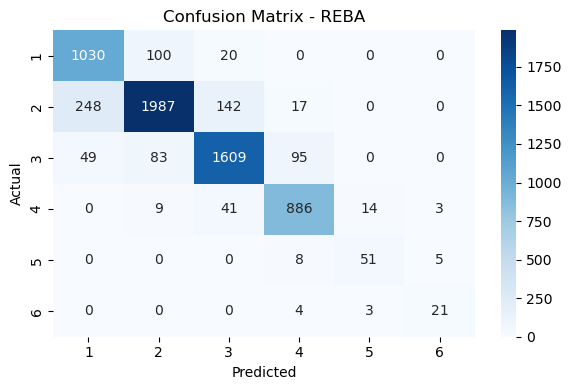

=== RULA Model Report ===
              precision    recall  f1-score   support

           2       0.87      0.98      0.92       819
           3       0.99      0.96      0.97      4191
           4       0.94      0.97      0.95      1231
           5       0.91      0.93      0.92       158
           6       0.77      0.88      0.82        26

    accuracy                           0.96      6425
   macro avg       0.90      0.94      0.92      6425
weighted avg       0.96      0.96      0.96      6425



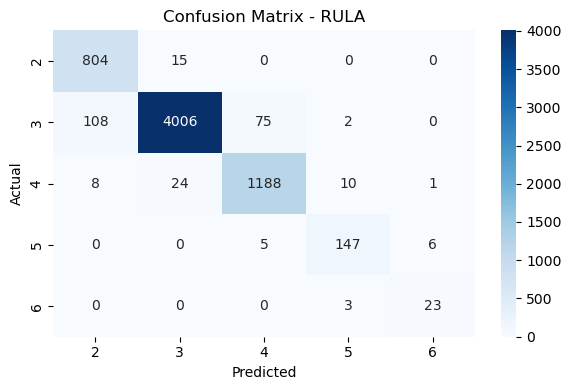

In [12]:
print("=== REBA Model Report ===")
print(classification_report(y_test_reba, y_pred_reba))
valid_labels_reba = sorted(set(y_test_reba) | set(y_pred_reba))
cm = confusion_matrix(y_test_reba, y_pred_reba, labels=valid_labels_reba)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_labels_reba, yticklabels=valid_labels_reba)
plt.title(f"Confusion Matrix - REBA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("=== RULA Model Report ===")
print(classification_report(y_test_rula, y_pred_rula))
valid_labels_rula = sorted(set(y_test_rula) | set(y_pred_rula))
cm = confusion_matrix(y_test_rula, y_pred_rula, labels=valid_labels_rula)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_labels_rula, yticklabels=valid_labels_rula)
plt.title(f"Confusion Matrix - RULA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

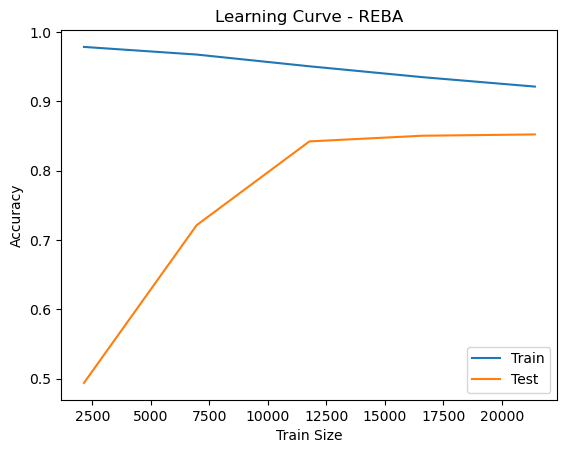

In [73]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    pipeline_reba, X_reba, y_reba, cv=3, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel("Train Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve - REBA")
plt.show()

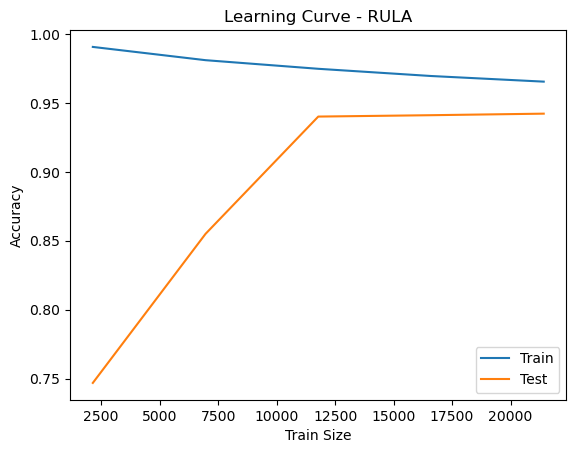

In [74]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Learning curve untuk RULA
train_sizes, train_scores, test_scores = learning_curve(
    pipeline_rula, X_rula, y_rula, cv=3, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Rata-rata skor
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot
plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel("Train Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve - RULA")
plt.show()

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ===== Fungsi Training SVM =====
def train_best_model(X_train, y_train, cv=3, n_iter=20):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('svc', SVC(class_weight='balanced'))
    ])

    param_dist = {
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'svc__kernel': ['rbf']
    }

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=True,
        random_state=42
    )
    search.fit(X_train, y_train)

    print("Best Parameters:", search.best_params_)
    print("Best CV Score:", search.best_score_)
    return search.best_estimator_, search  # return juga object search-nya untuk plotting

# ===== Fungsi Evaluasi Model =====
def evaluate_model(model, X_test, y_test, title="Model Evaluation"):
    y_pred = model.predict(X_test)

    print(f"\nClassification Report: {title}")
    print(classification_report(y_test, y_pred))

    valid_labels = sorted(set(y_test) | set(y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=valid_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=valid_labels, yticklabels=valid_labels)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# ===== Fungsi Grafik Line Akurasi =====
def plot_search_results(search, title="Tuning Results"):
    results = pd.DataFrame(search.cv_results_)
    results = results.sort_values(by='mean_test_score', ascending=False)

    plt.figure(figsize=(10, 5))
    plt.plot(results['mean_test_score'].values, marker='o')
    plt.title(f"{title} - Akurasi per Kombinasi")
    plt.xlabel("Kombinasi ke- (urut skor tertinggi)")
    plt.ylabel("Mean CV Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ===== Fungsi Heatmap Akurasi (khusus kernel tunggal) =====
def plot_heatmap(search, kernel='rbf', title="Heatmap Akurasi"):
    df = pd.DataFrame(search.cv_results_)
    df = df[df['param_svc__kernel'] == kernel]
    df = df[df['param_svc__gamma'] != 'auto']
    df = df[df['param_svc__gamma'] != 'scale']

    pivot = df.pivot_table(
        index='param_svc__C',
        columns='param_svc__gamma',
        values='mean_test_score',
        aggfunc='mean'
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='YlGnBu')
    plt.title(f"{title} ({kernel} kernel)")
    plt.xlabel("Gamma")
    plt.ylabel("C")
    plt.tight_layout()
    plt.show()

def plot_bar_linear_kernel(search, title="Linear Kernel Performance"):
    df = pd.DataFrame(search.cv_results_)
    df = df[df['param_svc__kernel'] == 'linear']

    if not df.empty:
        plt.figure(figsize=(8, 5))
        sns.barplot(data=df, x='param_svc__C', y='mean_test_score')
        plt.title(f"{title} (Linear Kernel)")
        plt.xlabel("C")
        plt.ylabel("Mean CV Accuracy")
        plt.tight_layout()
        plt.show()
    else:
        print("Tidak ada kombinasi linear kernel yang dicoba.")

def save_cv_results(search, filename):
    df = pd.DataFrame(search.cv_results_)
    df.to_csv(filename, index=False)
    print(f"Saved search results to {filename}")

Tuning Model REBA...
Best Parameters: {'svc__kernel': 'rbf', 'svc__gamma': 1, 'svc__C': 100}
Best CV Score: 0.8522180891600594

Classification Report: REBA - Train Set
              precision    recall  f1-score   support

           1       0.81      0.94      0.87      4602
           2       0.94      0.86      0.90      9577
           3       0.93      0.92      0.93      7343
           4       0.92      0.97      0.95      3809
           5       0.83      1.00      0.91       255
           6       0.97      1.00      0.98       114

    accuracy                           0.91     25700
   macro avg       0.90      0.95      0.92     25700
weighted avg       0.91      0.91      0.91     25700



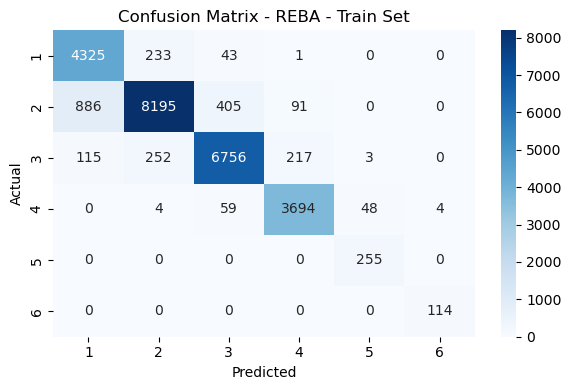


Classification Report: REBA - Test Set
              precision    recall  f1-score   support

           1       0.78      0.90      0.83      1150
           2       0.91      0.83      0.87      2394
           3       0.89      0.88      0.88      1836
           4       0.88      0.93      0.90       953
           5       0.75      0.80      0.77        64
           6       0.72      0.75      0.74        28

    accuracy                           0.87      6425
   macro avg       0.82      0.85      0.83      6425
weighted avg       0.87      0.87      0.87      6425



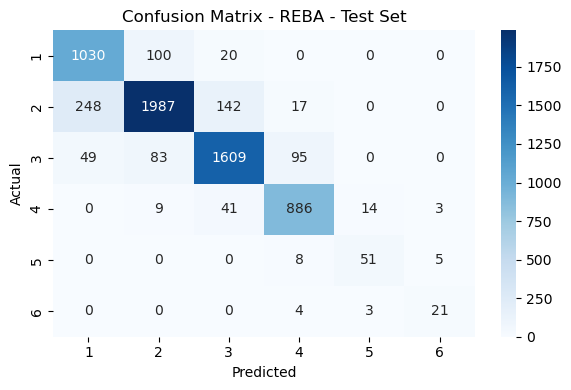

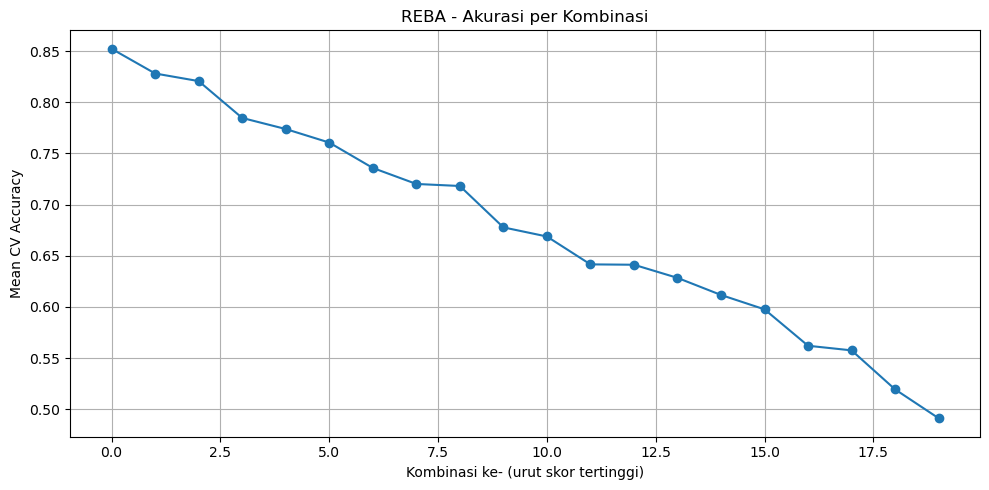

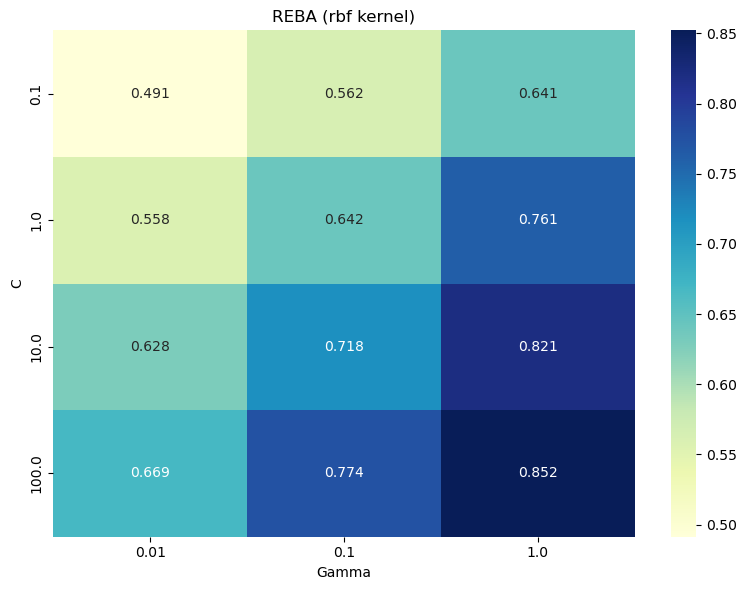

Tidak ada kombinasi linear kernel yang dicoba.
Saved search results to reba_tuning_results.csv

Tuning Model RULA...
Best Parameters: {'svc__kernel': 'rbf', 'svc__gamma': 1, 'svc__C': 100}
Best CV Score: 0.9582491028152441

Classification Report: RULA - Train Set
              precision    recall  f1-score   support

           2       0.90      1.00      0.95      3274
           3       1.00      0.97      0.98     16766
           4       0.96      0.99      0.98      4926
           5       0.96      1.00      0.98       631
           6       0.98      1.00      0.99       103

    accuracy                           0.98     25700
   macro avg       0.96      0.99      0.97     25700
weighted avg       0.98      0.98      0.98     25700



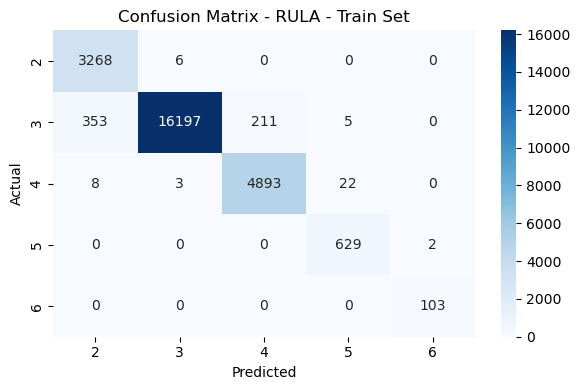


Classification Report: RULA - Test Set
              precision    recall  f1-score   support

           2       0.87      0.98      0.92       819
           3       0.99      0.96      0.97      4191
           4       0.94      0.97      0.95      1231
           5       0.91      0.93      0.92       158
           6       0.77      0.88      0.82        26

    accuracy                           0.96      6425
   macro avg       0.90      0.94      0.92      6425
weighted avg       0.96      0.96      0.96      6425



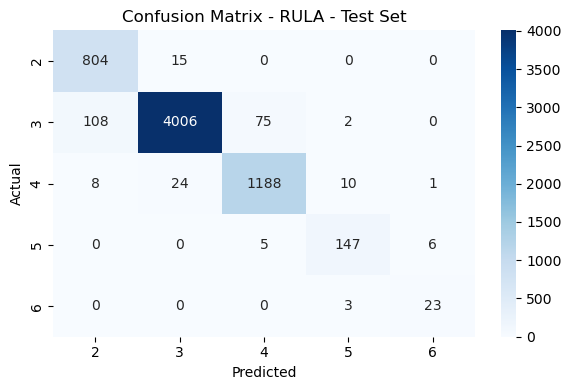

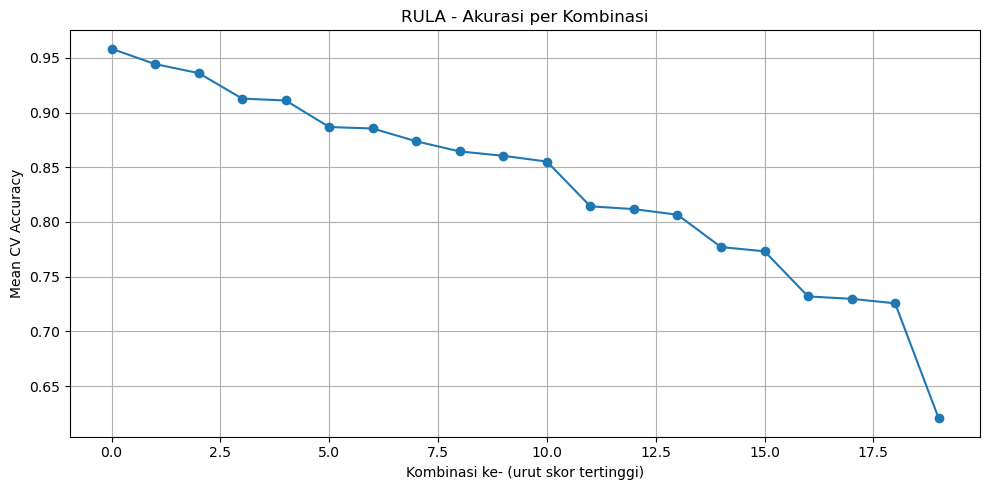

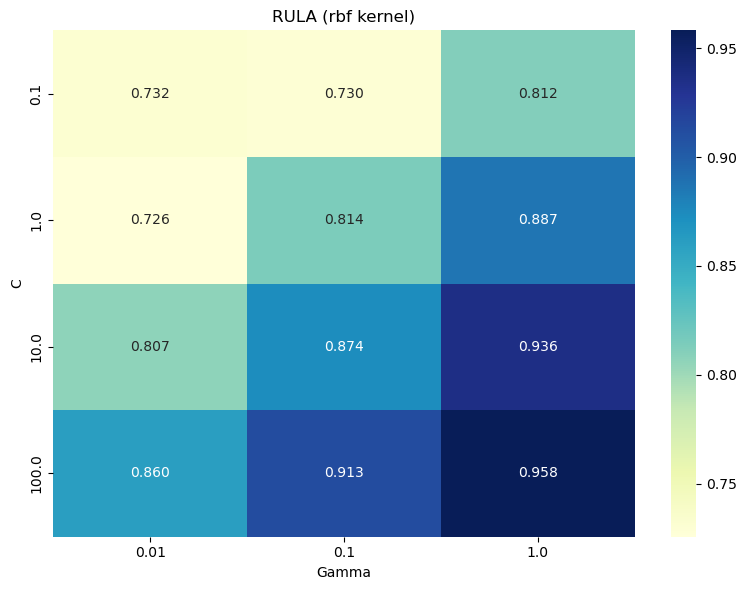

Tidak ada kombinasi linear kernel yang dicoba.
Saved search results to rula_tuning_results.csv


In [7]:
# === REBA ===
print("Tuning Model REBA...")
best_model_reba, search_reba = train_best_model(X_train_reba, y_train_reba)
evaluate_model(best_model_reba, X_train_reba, y_train_reba, title="REBA - Train Set")
evaluate_model(best_model_reba, X_test_reba, y_test_reba, title="REBA - Test Set")
plot_search_results(search_reba, title="REBA")
plot_heatmap(search_reba, kernel='rbf', title="REBA")
plot_bar_linear_kernel(search_reba, title="REBA")
save_cv_results(search_reba, "reba_tuning_results.csv")

# === RULA ===
print("\nTuning Model RULA...")
best_model_rula, search_rula = train_best_model(X_train_rula, y_train_rula)
evaluate_model(best_model_rula, X_train_rula, y_train_rula, title="RULA - Train Set")
evaluate_model(best_model_rula, X_test_rula, y_test_rula, title="RULA - Test Set")
plot_search_results(search_rula, title="RULA")
plot_heatmap(search_rula, kernel='rbf', title="RULA")
plot_bar_linear_kernel(search_rula, title="RULA")
save_cv_results(search_rula, "rula_tuning_results.csv")

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# === CROSS-VALIDATION REBA ===
print("Cross-Validation - REBA")
acc_scores_reba = cross_val_score(best_model_reba, X_reba, y_reba, cv=5, scoring='accuracy')
f1_scores_reba = cross_val_score(best_model_reba, X_reba, y_reba, cv=5, scoring=make_scorer(f1_score, average='macro'))

print("REBA Accuracy CV:", acc_scores_reba)
print("REBA Mean Accuracy:", acc_scores_reba.mean())
print("REBA Macro F1 CV:", f1_scores_reba)
print("REBA Mean Macro F1:", f1_scores_reba.mean())

print("\n")

# === CROSS-VALIDATION RULA ===
print("Cross-Validation - RULA")
acc_scores_rula = cross_val_score(best_model_rula, X_rula, y_rula, cv=5, scoring='accuracy')
f1_scores_rula = cross_val_score(best_model_rula, X_rula, y_rula, cv=5, scoring=make_scorer(f1_score, average='macro'))

print("RULA Accuracy CV:", acc_scores_rula)
print("RULA Mean Accuracy:", acc_scores_rula.mean())
print("RULA Macro F1 CV:", f1_scores_rula)
print("RULA Mean Macro F1:", f1_scores_rula.mean())

Cross-Validation - REBA
REBA Accuracy CV: [0.88513619 0.83844358 0.86505837 0.85431907 0.86101167]
REBA Mean Accuracy: 0.8607937743190661
REBA Macro F1 CV: [0.85558945 0.83226964 0.82911916 0.85094003 0.83730316]
REBA Mean Macro F1: 0.8410442874964211


Cross-Validation - RULA
RULA Accuracy CV: [0.96404669 0.95626459 0.96902724 0.96093385 0.96980545]
RULA Mean Accuracy: 0.9640155642023347
RULA Macro F1 CV: [0.94110951 0.91683661 0.92158232 0.93986911 0.93569434]
RULA Mean Macro F1: 0.9310183784327009


## Training Pipeline

# Input Keypoin predict

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
import cloudpickle

class PostureModel:
    def __init__(self):
        # Mapping fitur REBA/RULA
        self.feature_mapping = {
            # RULA per join
            'rula_upper_arm_score': ['sudut_bahu', 'conf_back', 'conf_shoulder', 'conf_elbow', 'adjust_shoulder_raised', 'adjust_arm_supported'],
            'rula_lower_arm_score': ['sudut_siku', 'conf_shoulder', 'conf_elbow', 'conf_wrist'],
            'rula_wrist_score': ['sudut_pergelangan', 'conf_elbow', 'conf_wrist', 'conf_hand_middle'],
            'rula_neck_score': ['sudut_leher', 'conf_neck', 'conf_head', 'conf_back', 'adjust_neck_twist'],
            'rula_trunk_score': ['sudut_punggung', 'conf_hip', 'conf_knee', 'adjust_trunk_twist', 'conf_shoulder', 'conf_shoulder_left', 'conf_elbow', 'conf_elbow_left'],
        
            # REBA per join
            'reba_upper_arm_score': ['sudut_bahu', 'conf_back', 'conf_shoulder', 'conf_elbow', 'adjust_shoulder_raised', 'adjust_arm_supported'],
            'reba_lower_arm_score': ['sudut_siku', 'conf_shoulder', 'conf_elbow', 'conf_wrist'],
            'reba_wrist_score': ['sudut_pergelangan', 'conf_elbow', 'conf_wrist', 'conf_hand_middle'],
            'reba_neck_score': ['sudut_leher', 'conf_neck', 'conf_head', 'conf_back', 'adjust_neck_twist'],
            'reba_trunk_score': ['sudut_punggung', 'conf_hip', 'conf_knee', 'adjust_trunk_twist', 'conf_shoulder', 'conf_shoulder_left', 'conf_elbow', 'conf_elbow_left'],
        
            # Final score rula
            'rula_final_score': ['sudut_bahu', 'sudut_siku', 'sudut_pergelangan',
                                 'sudut_leher', 'sudut_punggung', 'sudut_lutut',
            
                                 'conf_back', 'conf_shoulder', 'conf_elbow', 'conf_wrist',
                                 'conf_hand_middle', 'conf_neck', 'conf_head',
                                 'conf_hip', 'conf_knee', 'conf_ankle',
                                 'conf_shoulder_left', 'conf_elbow_left',
            
                                 'adjust_shoulder_raised', 'adjust_arm_supported',
                                 'adjust_neck_twist', 'adjust_trunk_twist', 'adjust_legs_feet', 'adjust_wrist_twist'],

            # Final score reba
            'reba_final_score': ['sudut_bahu', 'sudut_siku', 'sudut_pergelangan',
                                 'sudut_leher', 'sudut_punggung', 'sudut_lutut',
            
                                 'conf_back', 'conf_shoulder', 'conf_elbow', 'conf_wrist',
                                 'conf_hand_middle', 'conf_neck', 'conf_head',
                                 'conf_hip', 'conf_knee', 'conf_ankle',
                                 'conf_shoulder_left', 'conf_elbow_left',
            
                                 'adjust_shoulder_raised', 'adjust_arm_supported',
                                 'adjust_neck_twist', 'adjust_trunk_twist', 'adjust_legs_feet']
        }

        self.joint_models = {}       # model per sendi
        self.joint_scalers = {}      # scaler per sendi
        self.final_models = {}       # model akhir
        self.final_scalers = {}      # scaler akhir

    def fit(self, df):
        # Train joint models
        for target, features in self.feature_mapping.items():
            if "final_score" in target:
                continue
            X = df[features]
            y = df[target]

            if len(np.unique(y)) <= 1:
                print(f"Skipping {target} karena hanya ada 1 kelas.")
                continue

            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X)
            model = SVC(C=100, kernel='rbf', gamma=1, class_weight='balanced')
            model.fit(X_scaled, y)

            self.joint_models[target] = model
            self.joint_scalers[target] = scaler

        # Generate prediksi sendi ke df
        df_copy = df.copy()
        for target in self.joint_models:
            X = df[ self.feature_mapping[target] ]
            X_scaled = self.joint_scalers[target].transform(X)
            df_copy[target] = self.joint_models[target].predict(X_scaled)

        # Train final models
        for target in ['rula_final_score', 'reba_final_score']:
            features = self.feature_mapping[target]
            X = df_copy[features]
            y = df_copy[target]

            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X)

            model = SVC(C=100, kernel='rbf', gamma=1, class_weight='balanced')
            model.fit(X_scaled, y)

            self.final_models[target] = model
            self.final_scalers[target] = scaler

    def predict(self, df_row):
        result = OrderedDict()

        ordered_keys = [
            # RULA
            'rula_upper_arm_score',
            'rula_lower_arm_score',
            'rula_wrist_score',
            'rula_neck_score',
            'rula_trunk_score',
            'rula_leg_score',
            
            # REBA
            'reba_upper_arm_score',
            'reba_lower_arm_score',
            'reba_wrist_score',
            'reba_neck_score',
            'reba_trunk_score',
            'reba_leg_score',
            
            # Final
            'rula_final_score',
            'reba_final_score',
            
            # Feedback
            'feedback',
            'summary',
            'details'
        ]

        # Prediksi per sendi
        for target, model in self.joint_models.items():
            features = self.feature_mapping[target]
            X = df_row[features]
            X_scaled = self.joint_scalers[target].transform(X)
            pred = model.predict(X_scaled)
            result[target] = int(pred[0])

        # Prediksi final score
        for target, model in self.final_models.items():
            features = self.feature_mapping[target]
            input_data = {feat: result.get(feat, df_row.iloc[0][feat]) for feat in features}
            X_final = pd.DataFrame([input_data])
            X_scaled = self.final_scalers[target].transform(X_final)
            pred = model.predict(X_scaled)
            result[target] = int(pred[0])

        # Tambahkan manual untuk lutut (karena selalu 1 dan tidak diprediksi)
        result["rula_leg_score"] = 1
        result["reba_leg_score"] = 1

        result["feedback"] = self.generate_feedback(df_row)
        rula_score = result.get("rula_final_score", 0)
        reba_score = result.get("reba_final_score", 0)
        result["summary"] = self.final_score_feedback(rula_score, reba_score)
        result["details"] = {
            "sudut_lutut": df_row["sudut_lutut"].values[0],
            "sudut_siku": df_row["sudut_siku"].values[0],
            "sudut_leher": df_row["sudut_leher"].values[0],
            "sudut_punggung": df_row["sudut_punggung"].values[0],
            "sudut_pergelangan": df_row["sudut_pergelangan"].values[0],
            "sudut_bahu": df_row["sudut_bahu"].values[0],
        
            "adjust_shoulder_raised": df_row["adjust_shoulder_raised"].values[0],
            "adjust_arm_supported": df_row["adjust_arm_supported"].values[0],
            "adjust_neck_twist": df_row["adjust_neck_twist"].values[0],
            "adjust_trunk_twist": df_row["adjust_trunk_twist"].values[0],
            "adjust_legs_feet": df_row["adjust_legs_feet"].values[0],
            "adjust_wrist_twist": df_row["adjust_wrist_twist"].values[0],
        }
        result = OrderedDict((k, result[k]) for k in ordered_keys)
        return result

    def build_keypoints_dataframe(**kwargs):
        row = {}
        for key, val in kwargs.items():
            row[key] = [val]
        return pd.DataFrame(row)
        
    def predict_from_keypoints(self, keypoints_df):
        def calculate_angle(a, b, c):
            a = np.array(a)
            b = np.array(b)
            c = np.array(c)
            v1 = a - b
            v2 = c - b
            cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
            return np.degrees(angle)
        
        def calculate_wrist_bending(elbow, wrist, hand_middle):
            # vektor lengan bawah
            forearm_vec = np.array(wrist) - np.array(elbow)
            # vektor arah tangan
            hand_vec = np.array(hand_middle) - np.array(wrist)
            # hitung sudut antar dua vektor
            cosine = np.dot(forearm_vec, hand_vec) / (np.linalg.norm(forearm_vec) * np.linalg.norm(hand_vec))
            angle = np.arccos(np.clip(cosine, -1, 1))
            return np.degrees(angle)
        
        def calculate_neck_angle(back, neck, head):
            back = np.array(back)
            neck = np.array(neck)
            head = np.array(head)
        
            vertical_vec = neck - back     # vektor tubuh (vertikal)
            neck_vec = head - neck         # vektor arah leher
        
            cosine = np.dot(vertical_vec, neck_vec) / (np.linalg.norm(vertical_vec) * np.linalg.norm(neck_vec))
            angle = np.arccos(np.clip(cosine, -1.0, 1.0))
            return np.degrees(angle)
        
        def calculate_trunk_deviation(hip, neck):
            """
            Mengukur deviasi trunk (badan) terhadap garis vertikal dari hip ke atas.
            hip: (x, y) titik mid-hip (BODY_25 keypoint 8)
            neck: (x, y) titik neck (BODY_25 keypoint 1)
            """
            hip = np.array(hip)
            neck = np.array(neck)
            
            # Buat garis (vertikal ke atas dari hip, sejajar sumbu Y)
            ideal_neck = np.array([hip[0], neck[1]])
        
            # Vektor ideal (vertikal lurus)
            vertical_vec = hip - ideal_neck
            # Vektor tubuh aktual
            trunk_vec = hip - neck
        
            # Sudut antara keduanya
            cosine = np.dot(vertical_vec, trunk_vec) / (np.linalg.norm(vertical_vec) * np.linalg.norm(trunk_vec))
            angle = np.arccos(np.clip(cosine, -1.0, 1.0))
            return np.degrees(angle)
        
        def shoulder_is_raised(shoulder, neck, conf_shoulder, conf_neck, threshold=0.2):
            """
            Mengembalikan True jika shoulder lebih tinggi dari back (Y lebih kecil),
            dan confidence keduanya memadai.
            """
            if conf_shoulder > threshold and conf_neck > threshold:
                return shoulder[1] < neck[1]
            return False
        
        def arm_is_supported():
            """
            Diasumsikan duduk di kursi/meja → arm selalu disupport.
            """
            return True
        
        def is_neck_twisted(neck, nose, conf_neck, conf_nose, threshold=0.2):
            """
            Mengembalikan True jika posisi nose(0) di kiri neck(1) leher sedang twist
            """
            if conf_neck > threshold and conf_nose > threshold:
                return nose[0] < neck[0]
            elif conf_nose < 0.1:
                return True
            return False
        
        def is_trunk_twisted_by_elbow_rule(
            elbow_r, elbow_l,
            shoulder_r, shoulder_l,
            conf_er, conf_el,
            conf_sr, conf_sl,
            threshold=0.2
        ):
            if conf_er > threshold and conf_el > threshold and conf_sr > threshold and conf_sl > threshold:
                twist_kiri = elbow_r[0] < shoulder_l[0]  # Twist ke kiri / frontal
                twist_kanan = elbow_l[0] < shoulder_r[0]  # Twist ke kanan berlebihan
                return twist_kiri or twist_kanan
            return False
            
        def get_point(name):
            if name in keypoints_df.columns:
                value = keypoints_df[name].values[0]
                if len(value) == 3:
                    x, y, conf = value
                    if x == -1 or y == -1 or conf == -1:
                        return None, 0.0
                    return (x, y), conf
            return None, 0.0
    
        # Ambil semua titik yang dibutuhkan
        hip, conf_hip = get_point('hip')
        knee, conf_knee = get_point('knee')
        ankle, conf_ankle = get_point('ankle')
        shoulder, conf_shoulder = get_point('shoulder')
        shoulder_left, conf_shoulder_left = get_point('shoulder_left')
        elbow, conf_elbow = get_point('elbow')
        elbow_left, conf_elbow_left = get_point('elbow_left')
        wrist, conf_wrist = get_point('wrist')
        hand_middle, conf_hand_middle = get_point('hand_middle')
        back, conf_back = get_point('back')
        neck, conf_neck = get_point('neck')
        head, conf_head = get_point('head')
        nose, conf_nose = get_point('nose')
    
        # Hitung sudut
        flags = {}

        if hip and knee and ankle:
            sudut_lutut = calculate_angle(hip, knee, ankle)
            flags['sudut_lutut'] = False
        else:
            sudut_lutut = 90
            flags['sudut_lutut'] = True
    
        if shoulder and elbow and wrist:
            sudut_siku = abs(180 - calculate_angle(shoulder, elbow, wrist))
            flags['sudut_siku'] = False
        else:
            sudut_siku = 70
            flags['sudut_siku'] = True
    
        if back and neck and head:
            sudut_leher = calculate_neck_angle(back, neck, head)
            flags['sudut_leher'] = False
        else:
            sudut_leher = 10
            flags['sudut_leher'] = True
    
        if hip and neck:
            sudut_punggung = calculate_trunk_deviation(hip, neck)
            flags['sudut_punggung'] = False
        else:
            sudut_punggung = 10
            flags['sudut_punggung'] = True
    
        if elbow and wrist and hand_middle:
            sudut_pergelangan = calculate_wrist_bending(elbow, wrist, hand_middle)
            flags['sudut_pergelangan'] = False
        else:
            sudut_pergelangan = 10
            flags['sudut_pergelangan'] = True
    
        if back and shoulder and elbow:
            sudut_bahu = calculate_angle(back, shoulder, elbow)
            flags['sudut_bahu'] = False
        else:
            sudut_bahu = 10
            flags['sudut_bahu'] = True
    
        # Adjustments
        adjust_shoulder_raised = 1 if shoulder_is_raised(shoulder, neck, conf_shoulder, conf_neck) else 0
        adjust_arm_supported = -1 if arm_is_supported() else 0
        adjust_wrist_twist = 1  # selalu diset 1
        adjust_neck_twist = 1 if is_neck_twisted(neck, nose, conf_neck, conf_nose) else 0
        adjust_trunk_twist = 1 if is_trunk_twisted_by_elbow_rule(
            elbow, elbow_left,
            shoulder, shoulder_left,
            conf_elbow, conf_elbow_left,
            conf_shoulder, conf_shoulder_left
        ) else 0
        adjust_legs_feet = 1  # asumsi umum
    
        # Susun ke dalam dataframe 1 baris
        row = pd.DataFrame([{
            "sudut_lutut": sudut_lutut,
            "sudut_siku": sudut_siku,
            "sudut_leher": sudut_leher,
            "sudut_punggung": sudut_punggung,
            "sudut_pergelangan": sudut_pergelangan,
            "sudut_bahu": sudut_bahu,
    
            "conf_back": conf_back,
            "conf_shoulder": conf_shoulder,
            "conf_elbow": conf_elbow,
            "conf_wrist": conf_wrist,
            "conf_hand_middle": conf_hand_middle,
            "conf_neck": conf_neck,
            "conf_head": conf_head,
            "conf_hip": conf_hip,
            "conf_knee": conf_knee,
            "conf_ankle": conf_ankle,
            "conf_shoulder_left": conf_shoulder_left,
            "conf_elbow_left": conf_elbow_left,
    
            "adjust_shoulder_raised": adjust_shoulder_raised,
            "adjust_arm_supported": adjust_arm_supported,
            "adjust_neck_twist": adjust_neck_twist,
            "adjust_trunk_twist": adjust_trunk_twist,
            "adjust_legs_feet": adjust_legs_feet,
            "adjust_wrist_twist": adjust_wrist_twist
        }])
    
        result = self.predict(row)

        result["default_value_flags"] = flags
        return result

    def generate_feedback(self, df_row):
        messages = []
    
        # --- Upper Arm (Siku/Bahu) ---
        if df_row['sudut_bahu'].values[0] > 90:
            messages.append("Turunkan lengan agar tidak terlalu naik.")
        elif df_row['sudut_bahu'].values[0] > 60:
            messages.append("Usahakan menurunkan lengan saat bekerja.")
    
        if df_row['adjust_shoulder_raised'].values[0] == 1:
            messages.append("Rilekskan posisi bahu, bahu tampak terangkat.")
    
        # --- Elbow (Lower Arm) ---
        if df_row['sudut_siku'].values[0] > 100:
            messages.append("Sudut siku jangan terlalu tertekuk. Sebaiknya lebih lurus.")
        elif df_row['sudut_siku'].values[0] < 60:
            messages.append("Sudut siku jangan terlalu lurus. Sebaiknya lebih rileks.")
    
        # --- Wrist ---
        if df_row['sudut_pergelangan'].values[0] > 15:
            messages.append("Jaga sudut pergelangan tangan agar tidak terlalu membengkok.")
    
        # --- Neck ---
        if df_row['sudut_leher'].values[0] > 20:
            messages.append("Jaga leher sejajar kedepan, leher terlalu menunduk.")
    
        if df_row['adjust_neck_twist'].values[0] == 1:
            messages.append("Sesuaikan agar tetap lurus dan menghadap ke depan, leher dalam posisi menoleh.")
    
        # --- Trunk (Punggung) ---
        if df_row['sudut_punggung'].values[0] > 20:
            messages.append("Duduklah dengan tegak dan bersandar.")
    
        if df_row['adjust_trunk_twist'].values[0] == 1:
            messages.append("Duduk dengan lurus menghadap ke depan, hindari memutar badan saat duduk, punggung terpuntir.")
    
        # --- Legs ---
        if df_row['sudut_lutut'].values[0] > 120 or df_row['sudut_lutut'].values[0] < 60:
            messages.append("Buat sudut kaki ideal lurus kebawah dan menapakkan kaki dengan baik.")
    
        return " ".join(messages) if messages else "Postur Anda sudah cukup baik. Pertahankan!"

    def final_score_feedback(self, rula_score, reba_score):
        def interpret_rula(score):
            if score <= 2:
                return "Postur dapat diterima (acceptable posture)."
            elif score <= 4:
                return "Perlu investigasi lebih lanjut, mungkin butuh penyesuaian postur tubuh."
            elif score <= 6:
                return "Perlu investigasi lebih lanjut, butuh perubahan postur segera."
            else:
                return "Lakukan evaluasi dan ubah postur kerja sekarang juga."

        def interpret_reba(score):
            if score == 1:
                return "Risiko postur dapat diabaikan (Negligible Risk)."
            elif score <= 3:
                return "Risiko rendah. Perubahan postur mungkin dibutuhkan (Low Risk)."
            elif score <= 7:
                return "Risiko sedang. Lakukan investigasi lebih lanjut. Perubahan postur segera diperlukan (Medium Risk)."
            elif score <= 10:
                return "Risiko tinggi. Segera investigasi dan lakukan perubahan postur (High Risk)."
            else:
                return "Risiko sangat tinggi! Segera ubah postur kerja (Very High Risk)."
    
        return {
            "rula_summary": interpret_rula(rula_score),
            "reba_summary": interpret_reba(reba_score)
        }
    
    def save(self, path):
        with open(path, "wb") as f:
            cloudpickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            return cloudpickle.load(f)

In [14]:
df = pd.read_csv("/output_csv/dataset_rula_reba.csv")
df = df.dropna()

model = PostureModel()

model.fit(df)

model.save("/models/posture_model.pkl")

In [24]:
# Import hanya cloudpickle (tidak perlu ulangi class PostureModel)
import cloudpickle
import pandas as pd

# Load model
with open("app/models/posture_model.pkl", "rb") as f:
    model = cloudpickle.load(f)

df = pd.read_csv("app/output_csv/dataset_rula_reba.csv")
sample = df.iloc[[12]]
output = model.predict(sample)

import json
def to_serializable(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return str(obj)

print(json.dumps(output, indent=2, ensure_ascii=False, default=to_serializable))

c:\Users\Triska\ergonomicProject\Openpose-Backend\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Triska\ergonomicProject\Openpose-Backend\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{
  "rula_upper_arm_score": 1,
  "rula_lower_arm_score": 2,
  "rula_wrist_score": 3,
  "rula_neck_score": 3,
  "rula_trunk_score": 2,
  "rula_leg_score": 1,
  "reba_upper_arm_score": 1,
  "reba_lower_arm_score": 2,
  "reba_wrist_score": 2,
  "reba_neck_score": 2,
  "reba_trunk_score": 2,
  "reba_leg_score": 1,
  "rula_final_score": 3,
  "reba_final_score": 3,
  "feedback": "Sudut siku jangan terlalu tertekuk. Sebaiknya lebih lurus. Jaga sudut pergelangan tangan agar tidak terlalu membengkok. Jaga leher sejajar kedepan, leher terlalu menunduk.",
  "summary": {
    "rula_summary": "Perlu investigasi lebih lanjut, mungkin butuh penyesuaian postur tubuh.",
    "reba_summary": "Risiko rendah. Perubahan postur mungkin dibutuhkan (Low Risk)."
  },
  "details": {
    "sudut_lutut": 81.1239688978174,
    "sudut_siku": 108.61318690202344,
    "sudut_leher": 21.788749902476965,
    "sudut_punggung": 5.425250646059462,
    "sudut_pergelangan": 103.11579179065043,
    "sudut_bahu": 22.3951800754736

In [9]:
# Import hanya cloudpickle (tidak perlu ulangi class PostureModel)
import cloudpickle
import pandas as pd

# Load model
with open("app/models/posture_model.pkl", "rb") as f:
    model = cloudpickle.load(f)

df = pd.read_csv("app/output_csv/output_angles_reba_rula.csv")
sample = pd.DataFrame([{'hip': (-1, -1, -1), 'knee': (311.208740234375, 574.1769409179688, 0.9299176931381226), 'ankle': (279.02398681640625, 718.97802734375, 0.9126120805740356), 'shoulder': (145.15843200683594, 386.3792419433594, 0.8624446392059326), 'shoulder_left': (145.0896453857422, 365.3149719238281, 0.7952179908752441), 'elbow': (193.41151428222656, 488.191650390625, 0.9639016389846802), 'elbow_left': (188.28793334960938, 461.57525634765625, 0.381327360868454), 'wrist': (279.5908508300781, 482.7468566894531, 0.8852013349533081), 'hand_middle': (319.60302734375, 454.9108581542969, 0.7592580914497375), 'back': (155.88572692871094, 547.2257080078125, 0.7590545415878296), 'neck': (145.12112426757812, 370.5735168457031, 0.7592269778251648), 'head': (161.32247924804688, 316.52593994140625, 0.9215034246444702), 'nose': (209.47634887695312, 321.9300231933594, 0.9212725758552551)}])
output = model.predict_from_keypoints(sample)

import json
def to_serializable(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return str(obj)

print(json.dumps(output, indent=2, ensure_ascii=False, default=to_serializable))

{
  "rula_upper_arm_score": 1,
  "rula_lower_arm_score": 1,
  "rula_wrist_score": 3,
  "rula_neck_score": 3,
  "rula_trunk_score": 2,
  "rula_leg_score": 1,
  "reba_upper_arm_score": 1,
  "reba_lower_arm_score": 1,
  "reba_wrist_score": 2,
  "reba_neck_score": 1,
  "reba_trunk_score": 2,
  "reba_leg_score": 1,
  "rula_final_score": 3,
  "reba_final_score": 3,
  "feedback": "Jaga sudut pergelangan tangan agar tidak terlalu membengkok. Jaga leher sejajar kedepan, leher terlalu menunduk.",
  "summary": {
    "rula_summary": "Perlu investigasi lebih lanjut, mungkin butuh penyesuaian postur tubuh.",
    "reba_summary": "Risiko rendah. Perubahan postur mungkin dibutuhkan (Low Risk)."
  },
  "details": {
    "sudut_lutut": 90,
    "sudut_siku": 68.25693621342151,
    "sudut_leher": 20.173783832059772,
    "sudut_punggung": 10,
    "sudut_pergelangan": 31.210748482089354,
    "sudut_bahu": 21.542631617611576,
    "adjust_shoulder_raised": 0,
    "adjust_arm_supported": -1,
    "adjust_neck_twi

In [ ]:
{'hip': (150.88059997558594, 557.9376831054688, 0.8290873169898987), 'knee': (311.2087097167969, 574.1767578125, 0.9299174547195435), 'ankle': (279.02398681640625, 718.9781494140625, 0.9126119613647461), 'shoulder': (145.158447265625, 386.37921142578125, 0.8624442219734192), 'shoulder_left': (145.08966064453125, 365.3150634765625, 0.7952173352241516), 'elbow': (193.4114532470703, 488.1916198730469, 0.9639008045196533), 'elbow_left': (188.28793334960938, 461.5753173828125, 0.3813277781009674), 'wrist': (279.5908508300781, 482.74676513671875, 0.8852013945579529), 'hand_middle': (319.60302734375, 454.9107360839844, 0.7592132091522217), 'back': (155.88572692871094, 547.2257690429688, 0.7590542435646057), 'neck': (145.12112426757812, 370.5735168457031, 0.7592269778251648), 'head': (161.32247924804688, 316.52593994140625, 0.9215032458305359), 'nose': (209.4763946533203, 321.9300842285156, 0.9212728142738342)}

# LLM Output

## Prompt Engineering output from model

In [28]:
# Import hanya cloudpickle (tidak perlu ulangi class PostureModel)
import cloudpickle
import pandas as pd
import numpy as np
import json
import os

# Load model
with open("app/models/posture_model.pkl", "rb") as f:
    model = cloudpickle.load(f)

df = pd.read_csv("app/output_csv/dataset_rula_reba.csv")
sample = df.iloc[[1]]
output = model.predict(sample)

import json
def to_serializable(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return str(obj)

# Hapus atribut feedback dan summary jika ada
if isinstance(output, dict):
    output.pop("feedback", None)
    output.pop("summary", None)

os.makedirs("app/output_json", exist_ok=True)

with open("app/output_json/input_llm.json", "w", encoding="utf-8") as f:
    json.dump(output, f, indent=2, ensure_ascii=False, default=to_serializable)
    
print("Output saved to app/output_json/input_llm.json")

c:\Users\Triska\ergonomicProject\Openpose-Backend\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Triska\ergonomicProject\Openpose-Backend\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output saved to app/output_json/input_llm.json


In [ ]:
import json
from groq import Groq

# Baca file JSON hasil ML
with open(r"app/output_json/input_llm.json", "r", encoding="utf-8") as f:
    ml_output = json.load(f)

client = Groq(
        api_key="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"
)

completion = client.chat.completions.create(
    model="openai/gpt-oss-120b",
    messages=[
        {
            "role": "system",
            "content": (
                "Kamu adalah konsulen ergonomis profesional. Kamu memiliki pengetahuan ergonomis yang sangat luas dan kemampuan asesmen RULA dan REBA yang akurat.\n\n"
                
                
                "Tugasmu:\n"
                "1. Membaca data JSON yang diberikan.\n"
                "2. Menentukan masalah postur pengguna.\n"
                "3. Memberikan rekomendasi ergonomis yang spesifik dan praktis.\n"
                "4. Gunakan bahasa Indonesia yang sopan, friendly dan mudah dipahami.\n"
                "5. Gunakan pengetahuan tentang standar RULA dan REBA.\n"
                "6. Apabila terdapat sudut yang di luar batas wajar menurut RULA dan REBA, output wajib menunjukkan masalah tersebut. Review singkat keseluruhan sudut.\n"
                "Serta berikan rekomendasi postur berdasarkan skor RULA dan REBA\n"

            )
        },
        {
            "role": "user",
            "content": json.dumps(ml_output, ensure_ascii=False)
        }
    ],
    temperature=0.7,
    max_completion_tokens=4096,
    top_p=1,
    reasoning_effort="medium",
    stream=True,
    stop=None
)

for chunk in completion:
    print(chunk.choices[0].delta.content or "", end="")


**Hai! Terima kasih sudah membagikan data postur kerja Anda.**  
Berikut saya rangkum hasil penilaian **RULA** dan **REBA**, mengidentifikasi titik‑titik yang perlu diperhatikan, serta memberikan rekomendasi praktis agar Anda tetap nyaman dan aman saat bekerja.

---

## 1. Ringkasan Skor RULA & REBA

| Metode | Skor Akhir | Makna (menurut standar) |
|-------|-----------|-----------------------|
| **RULA** | **2** | Risiko **rendah** – postur masih baik, namun masih ada ruang perbaikan. |
| **REBA** | **1** | **Sangat rendah** – tidak ada bahaya akut, tetapi tetap penting menjaga posisi yang ergonomis. |

---

## 2. Review Singkat Semua Sudut

| Sudut | Nilai (°) | Keterangan |
|------|----------|-----------|
| **Lutut** | **≈ 80°** | Fleksion tinggi (lebih dari 60°). Bila dipertahankan lama dapat menambah beban pada sendi lutut dan punggung bawah. |
| **Siku** | **≈ 31°** | Dalam kisaran aman (0‑70°). Posisi baik. |
| **Bahu** | **≈ 31°** | Dalam batas normal (0‑45°). Tidak ada masalah

## RAG and Prompt Engineering

In [14]:
import cloudpickle
import pandas as pd
import numpy as np
import json
import os
from dotenv import load_dotenv
import fitz  # PyMuPDF for PDF processing
import requests
from bs4 import BeautifulSoup

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_cohere import CohereEmbeddings
from langchain.schema import Document

from groq import Groq

In [ ]:
# Load environment
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')  
os.environ['COHERE_API_KEY'] = os.getenv('COHERE_API_KEY')  # For embedding

# Load Posture model
with open("app/models/posture_model.pkl", "rb") as f:
    model = cloudpickle.load(f)

# Load dataset for RULA and REBA scores
df = pd.read_csv("app/output_csv/dataset_rula_reba.csv")
sample = df.iloc[[1]]
output = model.predict(sample)

c:\Users\Triska\ergonomicProject\Openpose-Backend\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Triska\ergonomicProject\Openpose-Backend\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
# Serialize non-standard objects for JSON
def to_serializable(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return str(obj)

# Remove unnecessary attributes like feedback and summary
if isinstance(output, dict):
    output.pop("feedback", None)
    output.pop("summary", None)

# Save output to JSON file
os.makedirs("app/output_json", exist_ok=True)
with open("app/output_json/input_llm.json", "w", encoding="utf-8") as f:
    json.dump(output, f, indent=2, ensure_ascii=False, default=to_serializable)

print("Output saved to app/output_json/input_llm.json")

# Load the RULA and REBA scores from the generated JSON
with open(r"app/output_json/input_llm.json", "r", encoding="utf-8") as f:
    ml_output = json.load(f)

Output saved to app/output_json/input_llm.json


In [12]:
# PDF Document Loader
def load_pdf(file_path):
    """Loads text from a PDF file and splits it into Document chunks."""
    doc = fitz.open(file_path)
    text = ""
    for page in doc:
        text += page.get_text()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
    chunks = text_splitter.split_text(text)
    return [Document(page_content=chunk, metadata={"source": file_path}) for chunk in chunks]

def load_url(url):
    """Loads and extracts text from a webpage into Document chunks."""
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    paragraphs = soup.find_all('p')
    text = ' '.join([para.get_text() for para in paragraphs])

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
    chunks = text_splitter.split_text(text)
    return [Document(page_content=chunk, metadata={"source": url}) for chunk in chunks]

In [35]:
# Load PDFs from local directory
pdf_files = [
    "ergo_reference/RULA-A-Step-by-Step-Guide1.pdf", 
    "ergo_reference/REBA-A-Step-by-Step-Guide.pdf",
    "ergo_reference/Ergonomic-Posture-Analysis-of-Automobile-Assembly-Jobs-based-on-Multi-Year-Observation-Data-Stanford-University.pdf"
    ] 
docs = []
for pdf_file in pdf_files:
    pdf_text_chunks = load_pdf(pdf_file)
    docs.extend(pdf_text_chunks)

# Load URLs from a list of URLs
urls = [
    "https://www.ccohs.ca/oshanswers/ergonomics/sitting/sitting_position.html",
    "https://www.physiotattva.com/blog/10-tips-to-improve-posture-and-ergonomics-physiotattva",
    "https://ssep.com.au/best-posture-for-sitting-at-a-desk-all-day/",
    "https://infinityhealth.ca/blog/creating-a-safe-and-comfortable-workplace-7-ergonomic-tips-for-business-owners-to-reduce-employee-injury/"
    ]
for url in urls:
    url_text_chunks = load_url(url)
    docs.extend(url_text_chunks)

# Set embedding model for RAG
embedding_model = CohereEmbeddings(model="embed-english-v3.0")

# Add documents to vectorstore
vectorstore = FAISS.from_documents(docs, embedding_model)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={'k': 4})

# Retrieve relevant documents using RAG
question = "What are the best ergonomic posture recommendations based on RULA and REBA?"

# Search for documents
docs_to_use = retriever.invoke(question)

# Prepare documents for input to LLM
def format_docs(docs):
    return "\n".join(
        f"<doc{i+1}>:\nTitle:{doc.metadata.get('title', 'N/A')}\n"
        f"Source:{doc.metadata.get('source', 'N/A')}\n"
        f"Content:{doc.page_content}\n</doc{i+1}>\n"
        for i, doc in enumerate(docs)
    )


In [37]:
# Initialize the LLM client for chat completion
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

completion = client.chat.completions.create(
    model="openai/gpt-oss-120b",
    messages=[
        {
            "role": "system",
            "content": (
                "Kamu adalah konsulen ergonomis profesional. Kamu bertugas untuk memberikan rekomendasi postur kepada user dari data postur user"
                
                "Tugasmu:\n"
                "1. Membaca data JSON yang diberikan.\n"
                "2. Menentukan masalah postur pengguna secara ringkas.\n"
                "3. Memberikan rekomendasi postur ergonomis yang spesifik terhadap data JSON user.\n"
                "4. Gunakan bahasa Indonesia yang sopan, friendly dan mudah dipahami.\n"
                "5. Gunakan pengetahuan tentang standar RULA dan REBA.\n"
                "6. Output wajib menunjukkan masalah postur HANYA JIKA terdapat sudut yang di luar batas wajar menurut RULA dan REBA\n"
                "7. Serta berikan rekomendasi postur berdasarkan skor RULA dan REBA\n"
                
                "Format yang diharapkan:\n"
                "1. Review skor RULA dan REBA user secara singkat\n"
                "1. Review sudut postur secara singkat\n"
                "2. Rekomendasi postur ergonomis berdasarkan postur user\n"
            )
        },
        {
            "role": "user",
            "content": json.dumps(ml_output, ensure_ascii=False)
        },
        {
            "role": "assistant",
            "content": f"Berikut adalah dokumen yang relevan:\n{format_docs(docs_to_use)}"
        }
    ],
    temperature=0.7,
    max_completion_tokens=4096,
    top_p=1,
    reasoning_effort="medium",
    stream=True,
    stop=None
)

# Print the LLM's response
generated_content = ""
for chunk in completion:
    delta = chunk.choices[0].delta.content
    if delta:
        generated_content += delta
        print(delta, end="")

**1. Review singkat skor RULA & REBA**  
- **RULA final score = 2**  (risiko rendah – masih dapat diterima, tetapi ada beberapa faktor yang menambah beban).  
- **REBA final score = 1**  (risiko sangat rendah).  

Meskipun skor akhir masih berada pada zona “aman”, beberapa sub‑skor menunjukkan posisi yang tidak ideal (mis‑score pada lengan bawah, pergelangan tangan, leher, dan lutut).

---

**2. Review singkat sudut postur**  

| Bagian tubuh | Sudut (°) | Batas wajar (menurut RULA/REBA) | Apakah di luar batas? |
|--------------|-----------|--------------------------------|-----------------------|
| Bahu (upper arm) | **31,2°** | ≤ 20° (neutral) → *tidak wajar*; namun karena lengan didukung (adjust_arm_supported = –1) skor menjadi 1. |
| Siku (lower arm) | **31,1°** (fleksi) | 0‑100° (fleksi ≤ 100°) → *wajar* pada RULA, tetapi nilai ini menandakan **fleksi cukup besar** yang menambah beban pada siku. |
| Pergelangan tangan | **5,9°** (deviasi) | ≤ 15° (neutral) → wajar, tetapi ada **tw

### RAG Validation

#### Track Document References

In [39]:
def track_documents_used(docs, generation):
    """
    Track if the generated response uses content from the documents.
    This can be done by checking the occurrence of keywords or phrases in the output.
    """
    used_docs = []
    for i, doc in enumerate(docs):
        if any(keyword.lower() in generation.lower() for keyword in doc.page_content.split()):
            title = doc.metadata.get('title', f'Document_{i+1}')
            used_docs.append(f"Document {i+1}: {title}")
    return used_docs

# Check which documents were used
used_documents = track_documents_used(docs_to_use, generated_content)
print("Documents used in the response:", used_documents)

Documents used in the response: ['Document 1: Document_1', 'Document 2: Document_2', 'Document 3: Document_3', 'Document 4: Document_4']


In [43]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import List

# Data model for highlighting used documents
class HighlightDocuments(BaseModel):
    """Return the specific part of a document used for answering the question."""
    id: List[str] = Field(..., description="List of id of docs used to answers the question")
    title: List[str] = Field(..., description="List of titles used to answers the question")
    source: List[str] = Field(..., description="List of sources used to answers the question")
    segment: List[str] = Field(..., description="List of direct segments from used documents that answers the question")

# Function to track which documents were used
def highlight_used_docs(generated_content, docs):
    """
    This function checks if the generated content used any of the document chunks.
    It compares the generated content to document chunks and highlights the used docs.
    """
    used_docs = []
    for i, doc in enumerate(docs):
        if doc.page_content.lower() in generated_content.lower():  # Check if the document content is referenced in the answer
            used_docs.append({
                "id": f"doc{i+1}",
                "title": doc.metadata.get("title", "N/A"),
                "source": doc.metadata.get("source", "N/A"),
                "segment": doc.page_content  # This is the segment used
            })
    return used_docs

# Highlight used documents based on the generated content
used_documents = highlight_used_docs(generated_content, docs_to_use)

# Output the used document segments
print("\nHighlighted used documents:")
for doc in used_documents:
    print(f"ID: {doc['id']}\nTitle: {doc['title']}\nSource: {doc['source']}\nText Segment: {doc['segment']}\n")



Highlighted used documents:
